# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


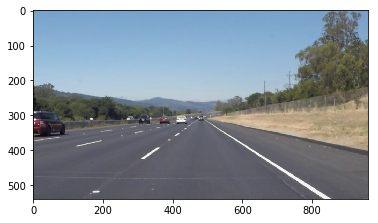

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

Thanks to Joao Sousa-Pinto for this link http://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

In [3]:
#class for storing and managing lane line data

class LaneLines:
    
    max_items = 20
    slopeThreshold_pct =  25
    interceptThreshold_pix = 75 
    y_top = 320
    y_bottom = 539
    min_slope = 0.25
    max_slope = 1
    
    class Line:
        def __init__(self, slope, intercept):
            self.slope = slope
            self.intercept = intercept
            self.count = 0
            
    def __init__(self):
        self.lineList = []
        
    def clearLineList(self):
        self.lineList = []
    
    def addToLineList(self, slope, intercept):
        #don't do anything if slope is outside of bounds
        if(abs(slope) > self.max_slope):
            return
        if(abs(slope) < self.min_slope):
            return
        
        
        #check to see if slope and intercept exist
        for line in self.lineList:
            if ((slope >= line.slope * 1 - self.slopeThreshold_pct/100)  #if the line already exists in the line list
            &(slope <= line.slope * 1 + self.slopeThreshold_pct/100) 
            &(intercept > line.intercept - self.interceptThreshold_pix) 
            &(intercept < line.intercept + self.interceptThreshold_pix)):
                #the line already exists, so add to the average
                line.count = line.count + 1
                line.slope = line.slope - line.slope/line.count + slope/line.count
                line.intercept = line.intercept - line.intercept/line.count + intercept/line.count
                return
        
        #if we got here there are no lines in the line list that match
        self.lineList.append(LaneLines.Line(slope,intercept))
                
    def drawLines(self, img, color, thickness):
        print ("Drawing Lines")
        for line in self.lineList:
            print ("combined: slope: " + str(line.slope) + " , intercept: " + str(line.intercept))
            
            if line.slope == 0:
                continue
            y1 = self.y_top
            y2 = self.y_bottom
            x1 = int((y1 - line.intercept) / line.slope)
            x2 = int((y2 - line.intercept) / line.slope)
            
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
        
                

In [4]:
import math
from scipy.stats import linregress


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_avglines(img, lines, color=[255, 0, 0], thickness=5):

    laneLines = LaneLines()
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept, r_value, p_value, std_err = linregress([x1,x2],[y1,y2]) 
            #print ("(" + str(x1) + ", " + str(y1) + ")" +", " + "(" + str(x2) + ", " + str(y2) + ")" )
            #print ("slope: " + str(slope) + " , intercept: " + str(intercept))
            laneLines.addToLineList(slope,intercept)
            
    laneLines.drawLines(img, color, thickness)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    laneLines = LaneLines()
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines, thickness = 15)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Some Helper functions

In [6]:
def  newPlot(image, debugPlot = True):
    if(debugPlot):
        plt.figure()
        plt.imshow(image)

In [7]:
# function for running the pipeline



def pipeline(thingToProcess, debugPlot = True):
    print("Processsing " + thingToProcess)
    
    #reading in an image
    image = mpimg.imread('test_images/' + thingToProcess)
    
    #convert to grayscale
    gray = grayscale(image)
    if False: #if(debugPlot):
        plt.figure()
        plt.imshow(gray, cmap='gray')
    
    #gaussian blur
    blur_gray = gaussian_blur(gray, pipelineParameters.gaussianBlurKernelSize)
    if False: #if(debugPlot):
        plt.figure()
        plt.imshow(blur_gray, cmap='gray')
    
    #Canny Edge Detction
    edges = canny(blur_gray, pipelineParameters.cannyLowThreshold, pipelineParameters.cannyHighThreshold)
    if(False):
        plt.figure()
        plt.imshow(edges, cmap='gray')
        
    #mask   
    masked_edges = region_of_interest(edges, pipelineParameters.vertices)  
    if(False):
        plt.figure()
        plt.imshow(masked_edges, cmap='gray')
        
    #hough
    line_img, lines = hough_lines(masked_edges, pipelineParameters.houghRho, pipelineParameters.houghTheta, \
                        pipelineParameters.houghThreshold, pipelineParameters.houghMinLineLen, \
                        pipelineParameters.houghMaxLineGap)
    
    draw_lines(line_img, lines, thickness = 15)
    
    if(False):
        plt.figure()
        plt.imshow(line_img, cmap='gray')
    
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    x = [pipelineParameters.maskCorner1[0], pipelineParameters.maskCorner2[0], pipelineParameters.maskCorner3[0], pipelineParameters.maskCorner4[0]]
    y = [pipelineParameters.maskCorner1[1], pipelineParameters.maskCorner2[1], pipelineParameters.maskCorner3[1], pipelineParameters.maskCorner4[1]]
    
    drawnLines = weighted_img(image,line_img)
    newPlot(drawnLines, debugPlot)
    #plt.plot(x, y, 'b--', lw=4)
    
    return

In [20]:
#pipeline parameters
class pipelineParameters:
    gaussianBlurKernelSize = 9
    
    cannyLowThreshold = 50
    cannyHighThreshold = 150
    
    maskCorner1 = (120, 539)
    maskCorner2 = (440, 320)
    maskCorner3 = (520, 320)
    maskCorner4 = (950, 539)
    
    vertices = np.array([[maskCorner1, maskCorner2, maskCorner3, maskCorner4]], dtype = np.int32)
    
    houghRho = 2
    houghTheta = np.pi/180
    houghThreshold = 15
    houghMinLineLen = 20
    houghMaxLineGap = 20

    
    

Processsing solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Processsing whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


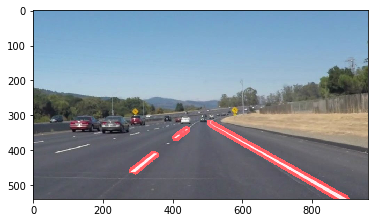

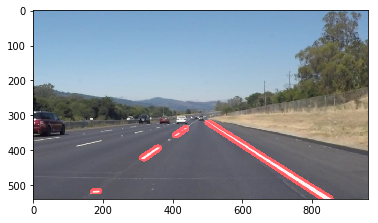

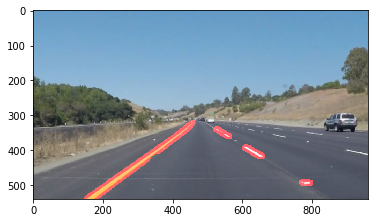

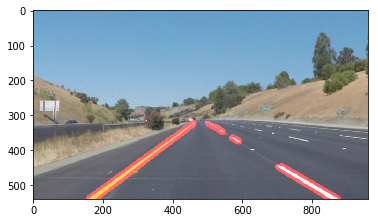

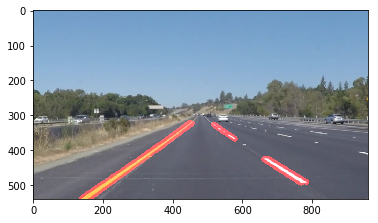

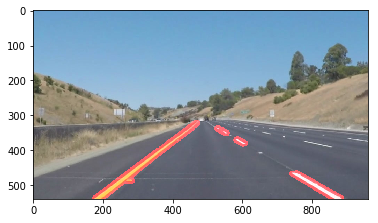

In [21]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
imageList = os.listdir("test_images/")
#imageList = [imageList[0]]
for image in imageList:
    pipeline(image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    #Read the image
    
    #reading in an image
    #image = mpimg.imread('test_images/' + thingToProcess)
    
    #convert to grayscale
    gray = grayscale(image)
    
    #gaussian blur
    blur_gray = gaussian_blur(gray, pipelineParameters.gaussianBlurKernelSize)
    
    #Canny Edge Detction
    edges = canny(blur_gray, pipelineParameters.cannyLowThreshold, pipelineParameters.cannyHighThreshold)
        
    #mask   
    masked_edges = region_of_interest(edges, pipelineParameters.vertices)  
        
    #hough
    line_img, lines = hough_lines(masked_edges, pipelineParameters.houghRho, pipelineParameters.houghTheta, \
                        pipelineParameters.houghThreshold, pipelineParameters.houghMinLineLen, \
                        pipelineParameters.houghMaxLineGap)
    
    draw_avglines(line_img, lines, thickness = 15)

    #printing out some stats and plotting
    x = [pipelineParameters.maskCorner1[0], pipelineParameters.maskCorner2[0], pipelineParameters.maskCorner3[0], pipelineParameters.maskCorner4[0]]
    y = [pipelineParameters.maskCorner1[1], pipelineParameters.maskCorner2[1], pipelineParameters.maskCorner3[1], pipelineParameters.maskCorner4[1]]
    
    
    drawnLines = weighted_img(image,line_img)
    #newPlot(drawnLines, debugPlot)
    #plt.plot(x, y, 'b--', lw=4)
    
    return drawnLines

Let's try the one with the solid white lane on the right first ...

In [25]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Drawing Lines
combined: slope: 0.613347324465 , intercept: 13.8019994033
combined: slope: -0.736312448187 , intercept: 656.313461291
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                                                                                                       | 0/222 [00:00<?, ?it/s]

Drawing Lines
combined: slope: 0.613347324465 , intercept: 13.8019994033
combined: slope: -0.736312448187 , intercept: 656.313461291
Drawing Lines
combined: slope: 0.617850188264 , intercept: 8.18008907005
combined: slope: -0.733891491885 , intercept: 653.437756577


  1%|█▍                                                                                                                                                             | 2/222 [00:00<00:11, 19.98it/s]

Drawing Lines
combined: slope: 0.606944545924 , intercept: 18.0776603301
combined: slope: -0.739233160196 , intercept: 658.096398208
Drawing Lines
combined: slope: 0.603739930252 , intercept: 20.9349246702
combined: slope: -0.702536454108 , intercept: 643.181148969
Drawing Lines
combined: slope: 0.607008551307 , intercept: 16.0662065734
combined: slope: -0.734510281385 , intercept: 655.281791126
Drawing Lines
combined: slope: 0.604915826062 , intercept: 19.9766900199
combined: slope: -0.708335921325 , intercept: 644.954296066


  3%|████▎                                                                                                                                                          | 6/222 [00:00<00:09, 22.25it/s]

Drawing Lines
combined: slope: 0.614680665428 , intercept: 8.846927281
combined: slope: -0.736656801331 , intercept: 654.648740865
Drawing Lines
combined: slope: 0.621236760901 , intercept: 3.72566341444
combined: slope: -0.741185091018 , intercept: 657.175532653
Drawing Lines
combined: slope: 0.603421806052 , intercept: 16.2599838646
combined: slope: -0.71692981536 , intercept: 648.136295332
Drawing Lines
combined: slope: 0.584101217656 , intercept: 29.0977408609
combined: slope: -0.725979154288 , intercept: 653.035991038


  5%|███████                                                                                                                                                       | 10/222 [00:00<00:08, 24.31it/s]

Drawing Lines
combined: slope: 0.640379801531 , intercept: -0.534478617369
combined: slope: -0.718885392578 , intercept: 653.817468519
combined: slope: 0.805555555556 , intercept: -86.0
Drawing Lines
combined: slope: 0.633230997261 , intercept: 2.30831117535
combined: slope: -0.746779872587 , intercept: 661.555912242
Drawing Lines
combined: slope: 0.635910873818 , intercept: 2.68250887698
combined: slope: -0.702051116205 , intercept: 644.067864804


  6%|█████████▎                                                                                                                                                    | 13/222 [00:00<00:08, 25.60it/s]

Drawing Lines
combined: slope: 0.635918772644 , intercept: -1.59252278734
combined: slope: -0.714860520867 , intercept: 646.381385529
Drawing Lines
combined: slope: 0.62432146608 , intercept: 10.3846069681
combined: slope: -0.662359771149 , intercept: 625.070190973
Drawing Lines
combined: slope: 0.637260997594 , intercept: -1.89037810243
combined: slope: -0.68220508658 , intercept: 630.796707251
Drawing Lines
combined: slope: 0.632480260239 , intercept: 0.434591336248
combined: slope: -0.696849446849 , intercept: 638.817700818


  8%|████████████                                                                                                                                                  | 17/222 [00:00<00:07, 27.20it/s]

Drawing Lines
combined: slope: 0.636704856087 , intercept: 1.41871654359
combined: slope: -0.707215103737 , intercept: 641.709429701
Drawing Lines
combined: slope: 0.631855297252 , intercept: 5.67776788606
combined: slope: -0.691288359788 , intercept: 638.455616402
Drawing Lines
combined: slope: 0.639761939798 , intercept: -1.65771536512
combined: slope: -0.702750093476 , intercept: 643.832915213


  9%|██████████████▏                                                                                                                                               | 20/222 [00:00<00:07, 27.18it/s]

Drawing Lines
combined: slope: 0.628964928054 , intercept: 9.39150934146
combined: slope: -0.721814146658 , intercept: 653.952196961
Drawing Lines
combined: slope: 0.622916575039 , intercept: 16.6550461069
combined: slope: -0.691267432049 , intercept: 640.247317065
Drawing Lines
combined: slope: 0.614064586989 , intercept: 16.7115699062
combined: slope: -0.698489315647 , intercept: 644.423987572


 10%|████████████████▎                                                                                                                                             | 23/222 [00:00<00:07, 26.52it/s]

Drawing Lines
combined: slope: 0.637632937907 , intercept: 3.90628639835
combined: slope: -0.709421362122 , intercept: 647.172475967
Drawing Lines
combined: slope: 0.645321687418 , intercept: -2.61317623656
combined: slope: -0.682236589218 , intercept: 640.046223371
Drawing Lines
combined: slope: 0.633639773588 , intercept: 2.19209795517
combined: slope: -0.7453738928 , intercept: 660.09262482


 12%|██████████████████▌                                                                                                                                           | 26/222 [00:00<00:07, 27.32it/s]

Drawing Lines
combined: slope: 0.63586126978 , intercept: 1.70971889278
combined: slope: -0.716293619404 , intercept: 647.653407601
Drawing Lines
combined: slope: 0.629926618712 , intercept: 2.06114855887
combined: slope: -0.688412873614 , intercept: 639.802453318
Drawing Lines
combined: slope: 0.632265640847 , intercept: 4.12760618645
combined: slope: -0.738218755882 , intercept: 659.069611095
Drawing Lines
combined: slope: 0.638780526644 , intercept: -0.568920430201
combined: slope: -0.738608191326 , intercept: 657.781978951


 14%|█████████████████████▎                                                                                                                                        | 30/222 [00:01<00:06, 28.23it/s]

Drawing Lines
combined: slope: 0.634950469946 , intercept: -2.35135667637
combined: slope: -0.710500317886 , intercept: 646.405024646
Drawing Lines
combined: slope: 0.64680275636 , intercept: -7.26366358867
combined: slope: -0.712315563178 , intercept: 646.506434322
Drawing Lines
combined: slope: 0.633728288701 , intercept: -1.86894223989
combined: slope: -0.714253181753 , intercept: 647.249403332
combined: slope: -0.904761904762 , intercept: 728.761904762


 15%|███████████████████████▍                                                                                                                                      | 33/222 [00:01<00:08, 22.65it/s]

Drawing Lines
combined: slope: 0.626839989203 , intercept: 3.65159054885
combined: slope: -0.71071229584 , intercept: 648.567026151
Drawing Lines
combined: slope: 0.642694062819 , intercept: -5.1845614533
combined: slope: -0.693998146185 , intercept: 640.176729161
Drawing Lines
combined: slope: 0.622298200834 , intercept: 7.33635148347
combined: slope: -0.694079631653 , intercept: 643.111413029


 16%|█████████████████████████▌                                                                                                                                    | 36/222 [00:01<00:08, 21.22it/s]

Drawing Lines
combined: slope: 0.617820344426 , intercept: 8.42062435684
combined: slope: -0.686225047229 , intercept: 639.757108737
Drawing Lines
combined: slope: 0.619627829422 , intercept: 9.01210420021
combined: slope: -0.744551476129 , intercept: 658.004124822
Drawing Lines
combined: slope: 0.644670464482 , intercept: -4.39404790536
combined: slope: -0.73434334913 , intercept: 655.651740171


 18%|███████████████████████████▊                                                                                                                                  | 39/222 [00:01<00:09, 18.78it/s]

Drawing Lines
combined: slope: 0.645874737894 , intercept: -8.24860591632
combined: slope: -0.715280120606 , intercept: 648.8410449
Drawing Lines
combined: slope: 0.626786154822 , intercept: 10.5447486883
combined: slope: -0.727559236255 , intercept: 653.316892528
Drawing Lines
combined: slope: 0.674862142907 , intercept: -27.3414062123
combined: slope: -0.724955566441 , intercept: 651.346228215
combined: slope: -0.541666666667 , intercept: 571.25


 19%|█████████████████████████████▉                                                                                                                                | 42/222 [00:01<00:09, 18.96it/s]

Drawing Lines
combined: slope: 0.658557724457 , intercept: -14.2877370535
combined: slope: -0.73582437276 , intercept: 654.115806452
Drawing Lines
combined: slope: 0.653085776807 , intercept: -13.5434887431
combined: slope: -0.72064894005 , intercept: 647.682466816


 20%|███████████████████████████████▎                                                                                                                              | 44/222 [00:01<00:09, 18.48it/s]

Drawing Lines
combined: slope: 0.662263862455 , intercept: -20.5141948034
combined: slope: -0.720942240849 , intercept: 649.457076034
Drawing Lines
combined: slope: 0.662087987218 , intercept: -17.5029486617
combined: slope: -0.743234543235 , intercept: 655.690698191


 21%|████████████████████████████████▋                                                                                                                             | 46/222 [00:01<00:09, 17.99it/s]

Drawing Lines
combined: slope: 0.650968363139 , intercept: -9.31387825022
combined: slope: -0.683878656948 , intercept: 633.780438263
Drawing Lines
combined: slope: 0.630219152463 , intercept: 5.20524157216
combined: slope: -0.710228265205 , intercept: 640.968705218


 22%|██████████████████████████████████▏                                                                                                                           | 48/222 [00:02<00:12, 13.55it/s]

Drawing Lines
combined: slope: 0.657372727875 , intercept: -13.6336831769
combined: slope: -0.753914787132 , intercept: 659.338162987
Drawing Lines
combined: slope: 0.633712686926 , intercept: -2.25831674303
combined: slope: -0.738624956571 , intercept: 652.81029345
Drawing Lines
combined: slope: 0.662824607645 , intercept: -18.6634391571
combined: slope: -0.701502704869 , intercept: 638.835877914
combined: slope: 0.761904761905 , intercept: -93.380952381


 23%|████████████████████████████████████▎                                                                                                                         | 51/222 [00:02<00:11, 14.88it/s]

Drawing Lines
combined: slope: 0.617636605423 , intercept: 8.75804899761
combined: slope: -0.701363440645 , intercept: 640.755298372
Drawing Lines
combined: slope: 0.64117170532 , intercept: -3.52374547589
combined: slope: -0.706453248894 , intercept: 639.02266527


 24%|█████████████████████████████████████▋                                                                                                                        | 53/222 [00:02<00:21,  8.00it/s]

Drawing Lines
combined: slope: 0.649214910714 , intercept: -6.41341199573
combined: slope: -0.701716596161 , intercept: 638.955851967
Drawing Lines
combined: slope: 0.647367143854 , intercept: -7.6123089617
combined: slope: -0.701922408604 , intercept: 638.056175158
combined: slope: 0.459459459459 , intercept: 101.081081081


 25%|███████████████████████████████████████▏                                                                                                                      | 55/222 [00:03<00:21,  7.69it/s]

Drawing Lines
combined: slope: 0.629991584772 , intercept: 9.85707276013
combined: slope: -0.706193558817 , intercept: 641.503380778
Drawing Lines
combined: slope: 0.653576125768 , intercept: -10.5392501354
combined: slope: -0.679999056573 , intercept: 633.25272197
Drawing Lines
combined: slope: 0.645357592468 , intercept: -2.15984964343
combined: slope: -0.66247936754 , intercept: 626.067493179


 26%|█████████████████████████████████████████▎                                                                                                                    | 58/222 [00:03<00:17,  9.51it/s]

Drawing Lines
combined: slope: 0.654241236254 , intercept: -11.0505476329
combined: slope: -0.70826818522 , intercept: 642.37442752
Drawing Lines
combined: slope: 0.662768530798 , intercept: -13.9193667202
combined: slope: -0.726053259097 , intercept: 648.373031445


 27%|██████████████████████████████████████████▋                                                                                                                   | 60/222 [00:03<00:20,  7.97it/s]

Drawing Lines
combined: slope: 0.668745675945 , intercept: -15.0706313367
combined: slope: -0.72462744833 , intercept: 649.798621227
Drawing Lines
combined: slope: 0.674812423075 , intercept: -20.546446181
combined: slope: -0.698300007071 , intercept: 637.382349336


 28%|████████████████████████████████████████████▏                                                                                                                 | 62/222 [00:03<00:18,  8.69it/s]

Drawing Lines
combined: slope: 0.659866176285 , intercept: -11.9230841026
combined: slope: -0.672562167724 , intercept: 630.656213342
Drawing Lines
combined: slope: 0.664344633908 , intercept: -13.1544781604
combined: slope: -0.674022072597 , intercept: 627.360456066


 29%|█████████████████████████████████████████████▌                                                                                                                | 64/222 [00:04<00:16,  9.81it/s]

Drawing Lines
combined: slope: 0.664103132931 , intercept: -13.2052780516
combined: slope: -0.671303290554 , intercept: 629.738419948
Drawing Lines
combined: slope: 0.678397702333 , intercept: -20.966219938
combined: slope: -0.68205083966 , intercept: 632.640735874
combined: slope: 0.451612903226 , intercept: 106.129032258


 30%|██████████████████████████████████████████████▉                                                                                                               | 66/222 [00:04<00:14, 10.53it/s]

Drawing Lines
combined: slope: 0.665394751286 , intercept: -16.956233744
combined: slope: -0.680752883345 , intercept: 630.317606688
combined: slope: 0.782608695652 , intercept: -104.304347826
Drawing Lines
combined: slope: 0.663670405439 , intercept: -12.4892627473
combined: slope: -0.67798185941 , intercept: 629.440113379
combined: slope: -0.3 , intercept: 544.3


 31%|████████████████████████████████████████████████▍                                                                                                             | 68/222 [00:04<00:13, 11.61it/s]

Drawing Lines
combined: slope: 0.659031577671 , intercept: -9.34568861791
combined: slope: -0.653186894445 , intercept: 619.958431775
Drawing Lines
combined: slope: 0.661755608762 , intercept: -12.9171759253
combined: slope: -0.656121577029 , intercept: 621.426921543


 32%|█████████████████████████████████████████████████▊                                                                                                            | 70/222 [00:04<00:12, 12.53it/s]

Drawing Lines
combined: slope: 0.673466532832 , intercept: -19.4862327128
combined: slope: -0.697886191514 , intercept: 637.519308578
Drawing Lines
combined: slope: 0.664992335929 , intercept: -10.8084361039
combined: slope: -0.681065274251 , intercept: 630.629102252


 32%|███████████████████████████████████████████████████▏                                                                                                          | 72/222 [00:04<00:11, 13.32it/s]

Drawing Lines
combined: slope: -0.665135013071 , intercept: 625.504137291
combined: slope: 0.677478249226 , intercept: -25.1432058712
Drawing Lines
combined: slope: 0.6560210808 , intercept: -10.2272090783
combined: slope: -0.683497759512 , intercept: 631.261176161
Drawing Lines
combined: slope: 0.676988687336 , intercept: -18.7497169579
combined: slope: -0.655799836057 , intercept: 621.003090097
combined: slope: 0.32 , intercept: 210.8


 34%|█████████████████████████████████████████████████████▍                                                                                                        | 75/222 [00:04<00:09, 15.02it/s]

Drawing Lines
combined: slope: 0.66548520764 , intercept: -16.253119623
combined: slope: -0.662525485504 , intercept: 621.004459061
Drawing Lines
combined: slope: 0.65703538954 , intercept: -4.60881948354
combined: slope: -0.689751714966 , intercept: 632.88332178


 35%|██████████████████████████████████████████████████████▊                                                                                                       | 77/222 [00:04<00:09, 14.81it/s]

Drawing Lines
combined: slope: 0.640670546538 , intercept: 6.45891331094
combined: slope: -0.669083054627 , intercept: 624.135482163
Drawing Lines
combined: slope: 0.653394837335 , intercept: -0.883796305353
combined: slope: -0.665014335074 , intercept: 621.630919712


 36%|████████████████████████████████████████████████████████▏                                                                                                     | 79/222 [00:04<00:09, 14.84it/s]

Drawing Lines
combined: slope: 0.665297133086 , intercept: -12.1139864691
combined: slope: -0.664358122996 , intercept: 622.421925117
combined: slope: 0.925925925926 , intercept: -148.518518519
combined: slope: 0.481481481481 , intercept: 88.4074074074
Drawing Lines
combined: slope: 0.677638226279 , intercept: -18.5154488603
combined: slope: -0.65860377574 , intercept: 620.141605129
Drawing Lines
combined: slope: 0.676993964628 , intercept: -17.6995437536
combined: slope: -0.681677304999 , intercept: 629.59124092


 37%|██████████████████████████████████████████████████████████▎                                                                                                   | 82/222 [00:05<00:08, 16.49it/s]

Drawing Lines
combined: slope: 0.674128984945 , intercept: -17.2458067754
combined: slope: -0.636790497102 , intercept: 612.020950203
Drawing Lines
combined: slope: 0.642230516565 , intercept: 0.85037903993
combined: slope: -0.669715410712 , intercept: 622.213356888
combined: slope: 0.456439393939 , intercept: 95.3087121212
combined: slope: 0.757575757576 , intercept: -74.6363636364


 38%|███████████████████████████████████████████████████████████▊                                                                                                  | 84/222 [00:05<00:09, 15.29it/s]

Drawing Lines
combined: slope: 0.699552411153 , intercept: -36.2928660224
combined: slope: -0.646614637269 , intercept: 617.372197642
combined: slope: 0.538461538462 , intercept: 53.3076923077
Drawing Lines
combined: slope: 0.672010173317 , intercept: -20.3880026534
combined: slope: -0.66463119827 , intercept: 622.389378626
Drawing Lines
combined: slope: 0.658696422708 , intercept: -7.95930355936
combined: slope: -0.65309257168 , intercept: 618.706938798


 39%|█████████████████████████████████████████████████████████████▉                                                                                                | 87/222 [00:05<00:08, 15.63it/s]

Drawing Lines
combined: slope: 0.678472758992 , intercept: -21.993576587
combined: slope: -0.666702395627 , intercept: 625.993751895
Drawing Lines
combined: slope: 0.655383139949 , intercept: -10.0795452487
combined: slope: -0.667434681261 , intercept: 624.88784737
combined: slope: 0.481481481481 , intercept: 81.3703703704


 40%|███████████████████████████████████████████████████████████████▎                                                                                              | 89/222 [00:05<00:08, 15.26it/s]

Drawing Lines
combined: slope: 0.681601447806 , intercept: -23.8163218649
combined: slope: -0.656175950486 , intercept: 619.206456676
combined: slope: -0.857142857143 , intercept: 707.285714286
Drawing Lines
combined: slope: 0.668466434985 , intercept: -15.2801891321
combined: slope: -0.635887375914 , intercept: 613.657298524
Drawing Lines
combined: slope: 0.687311842829 , intercept: -25.080350898
combined: slope: -0.65826513398 , intercept: 622.676059608
combined: slope: 0.933333333333 , intercept: -154.933333333


 41%|█████████████████████████████████████████████████████████████████▍                                                                                            | 92/222 [00:05<00:07, 16.99it/s]

Drawing Lines
combined: slope: 0.719170987211 , intercept: -44.5020098511
combined: slope: -0.672045126015 , intercept: 628.586592669
Drawing Lines
combined: slope: 0.664058188081 , intercept: -8.87940772879
combined: slope: -0.660803993863 , intercept: 624.410425711
combined: slope: -0.851851851852 , intercept: 705.555555556


 42%|██████████████████████████████████████████████████████████████████▉                                                                                           | 94/222 [00:05<00:07, 16.27it/s]

Drawing Lines
combined: slope: 0.706189650729 , intercept: -37.1010899389
combined: slope: -0.686173727588 , intercept: 634.830928644
Drawing Lines
combined: slope: 0.682667662389 , intercept: -23.6303299487
combined: slope: -0.71913278612 , intercept: 645.057280972
combined: slope: 0.959166666667 , intercept: -178.471666667
combined: slope: 0.483870967742 , intercept: 77.1612903226


 43%|████████████████████████████████████████████████████████████████████▎                                                                                         | 96/222 [00:05<00:07, 15.87it/s]

Drawing Lines
combined: slope: 0.695260742715 , intercept: -30.3365977824
combined: slope: -0.66460918544 , intercept: 625.435146329
Drawing Lines
combined: slope: 0.687469240295 , intercept: -26.8193964784
combined: slope: -0.684105325452 , intercept: 628.717645633
Drawing Lines
combined: slope: 0.672631671798 , intercept: -22.4660406187
combined: slope: -0.667425631506 , intercept: 622.101458733


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                       | 99/222 [00:06<00:07, 16.69it/s]

Drawing Lines
combined: slope: 0.688092936022 , intercept: -28.0981292378
combined: slope: -0.66489940761 , intercept: 623.992428799
Drawing Lines
combined: slope: 0.705309696893 , intercept: -39.401392226
combined: slope: -0.695791797136 , intercept: 637.414439197


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 101/222 [00:06<00:07, 16.50it/s]

Drawing Lines
combined: slope: 0.684643846222 , intercept: -26.3815154682
combined: slope: -0.64310250596 , intercept: 617.783924647
Drawing Lines
combined: slope: 0.720359960194 , intercept: -50.1623111311
combined: slope: -0.689409772756 , intercept: 637.982351251
combined: slope: -0.451612903226 , intercept: 535.064516129
Drawing Lines
combined: slope: 0.677258605754 , intercept: -18.1182168543
combined: slope: -0.676611300944 , intercept: 632.644580438


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 104/222 [00:06<00:06, 18.00it/s]

Drawing Lines
combined: slope: 0.693847415486 , intercept: -35.5689130687
combined: slope: -0.687706284971 , intercept: 636.808855193
Drawing Lines
combined: slope: 0.687818153384 , intercept: -31.6492344044
combined: slope: -0.702967556674 , intercept: 641.46128266


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 106/222 [00:06<00:06, 17.19it/s]

Drawing Lines
combined: slope: 0.662315470392 , intercept: -15.6581525732
combined: slope: -0.644365525707 , intercept: 619.771793274
combined: slope: -0.92 , intercept: 733.28
Drawing Lines
combined: slope: 0.682486754187 , intercept: -29.8362632027
combined: slope: -0.699767764668 , intercept: 638.919621707


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 108/222 [00:06<00:07, 16.08it/s]

Drawing Lines
combined: slope: 0.698818842819 , intercept: -39.548915846
combined: slope: -0.707754379629 , intercept: 643.124684297
Drawing Lines
combined: slope: 0.686614507246 , intercept: -30.159835981
combined: slope: -0.682521624033 , intercept: 634.989353138
Drawing Lines
combined: slope: 0.680207557327 , intercept: -25.0913526507
combined: slope: -0.665305435305 , intercept: 628.642227032


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 111/222 [00:06<00:06, 16.91it/s]

Drawing Lines
combined: slope: 0.684656024208 , intercept: -26.7567781244
combined: slope: -0.700913158391 , intercept: 638.687719994
combined: slope: 0.36 , intercept: 190.04
Drawing Lines
combined: slope: 0.706515918811 , intercept: -41.1872331157
combined: slope: -0.699795703057 , intercept: 639.903756346
combined: slope: 0.892857142857 , intercept: -147.428571429


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 113/222 [00:06<00:06, 15.85it/s]

Drawing Lines
combined: slope: 0.66801505069 , intercept: -21.3129793345
combined: slope: -0.686182024497 , intercept: 635.182576934
combined: slope: 0.795454545455 , intercept: -87.8409090909
Drawing Lines
combined: slope: 0.659971866736 , intercept: -17.5212748753
combined: slope: -0.660736298517 , intercept: 625.575134933
Drawing Lines
combined: slope: 0.677950716286 , intercept: -29.4913624704
combined: slope: -0.658095238095 , intercept: 623.660952381
combined: slope: 0.473684210526 , intercept: 87.6842105263


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 116/222 [00:07<00:06, 16.24it/s]

Drawing Lines
combined: slope: 0.67197813994 , intercept: -22.7124616616
combined: slope: -0.674152010994 , intercept: 630.111793562
Drawing Lines
combined: slope: 0.667842503035 , intercept: -20.5627926489
combined: slope: -0.680341530552 , intercept: 630.198789516


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 118/222 [00:07<00:06, 15.97it/s]

Drawing Lines
combined: slope: 0.672872541498 , intercept: -23.6620242964
combined: slope: -0.653381674533 , intercept: 621.501567044
combined: slope: -0.916666666667 , intercept: 733.75
Drawing Lines
combined: slope: 0.651685195809 , intercept: -7.58507195232
combined: slope: -0.694057530586 , intercept: 637.770770655


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 120/222 [00:07<00:06, 16.19it/s]

Drawing Lines
combined: slope: 0.655275379267 , intercept: -13.6005455555
combined: slope: -0.685129203196 , intercept: 636.19052227
Drawing Lines
combined: slope: 0.651693128152 , intercept: -9.55321624379
combined: slope: -0.670345748665 , intercept: 634.577235096
Drawing Lines
combined: slope: 0.640720214092 , intercept: -2.39353605659
combined: slope: -0.658268700392 , intercept: 625.254215773


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 123/222 [00:07<00:05, 18.18it/s]

Drawing Lines
combined: slope: 0.637864839231 , intercept: -1.62697295394
combined: slope: -0.683136167747 , intercept: 636.954970368
Drawing Lines
combined: slope: 0.641195044481 , intercept: -3.04664997321
combined: slope: -0.662296418303 , intercept: 628.996423599
combined: slope: 0.952380952381 , intercept: -168.428571429


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 125/222 [00:07<00:06, 15.88it/s]

Drawing Lines
combined: slope: 0.630312753979 , intercept: 2.84537640512
combined: slope: -0.682896124053 , intercept: 635.859040696
Drawing Lines
combined: slope: 0.640381005345 , intercept: -1.78753599811
combined: slope: -0.700326671897 , intercept: 643.716273518
Drawing Lines
combined: slope: 0.639607322079 , intercept: -0.722650469207
combined: slope: -0.703341892312 , intercept: 646.795135777


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 128/222 [00:07<00:05, 17.74it/s]

Drawing Lines
combined: slope: 0.635435312425 , intercept: -1.3926763107
combined: slope: -0.701231725428 , intercept: 644.488326147
Drawing Lines
combined: slope: 0.632299770364 , intercept: -3.32226782502
combined: slope: -0.720670192226 , intercept: 653.250806352


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 130/222 [00:07<00:05, 17.26it/s]

Drawing Lines
combined: slope: 0.635332964564 , intercept: -4.13494863682
combined: slope: -0.68248001248 , intercept: 639.748020748
Drawing Lines
combined: slope: 0.631364181781 , intercept: -0.725643769496
combined: slope: -0.702225474118 , intercept: 648.041673268


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 132/222 [00:08<00:05, 15.99it/s]

Drawing Lines
combined: slope: 0.640964793435 , intercept: -8.15293159796
combined: slope: -0.75503313284 , intercept: 667.148779209
Drawing Lines
combined: slope: 0.626132198217 , intercept: 2.16605841602
combined: slope: -0.70199497773 , intercept: 646.964201637
Drawing Lines
combined: slope: 0.634292984193 , intercept: -2.01748550479
combined: slope: -0.683351842305 , intercept: 635.322058512


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 135/222 [00:08<00:04, 17.93it/s]

Drawing Lines
combined: slope: 0.64322272002 , intercept: -8.82456169009
combined: slope: -0.693215812307 , intercept: 638.296245664
Drawing Lines
combined: slope: 0.612198245105 , intercept: 8.87025506513
combined: slope: -0.707858550095 , intercept: 645.641353571


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 137/222 [00:08<00:05, 15.63it/s]

Drawing Lines
combined: slope: 0.631782919306 , intercept: -4.73137293855
combined: slope: -0.737301587302 , intercept: 657.509365079
Drawing Lines
combined: slope: 0.629686167908 , intercept: 0.903783298947
combined: slope: -0.707573891626 , intercept: 646.306403941
Drawing Lines
combined: slope: 0.645145318757 , intercept: -12.599424614
combined: slope: -0.700227896324 , intercept: 645.164827954


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 140/222 [00:08<00:04, 16.91it/s]

Drawing Lines
combined: slope: 0.612842035639 , intercept: 14.8219173318
combined: slope: -0.738593081025 , intercept: 661.605456699
combined: slope: 1.0 , intercept: -242.0
combined: slope: -0.53125 , intercept: 572.8125
Drawing Lines
combined: slope: 0.633192853295 , intercept: 4.81735997504
combined: slope: -0.715953096107 , intercept: 652.44302107


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 142/222 [00:08<00:04, 17.18it/s]

Drawing Lines
combined: slope: 0.647284634626 , intercept: -10.0590765433
combined: slope: -0.72295492174 , intercept: 654.37705119
Drawing Lines
combined: slope: 0.635010220022 , intercept: 0.193944185818
combined: slope: -0.728787011258 , intercept: 658.592563285


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 144/222 [00:08<00:04, 16.37it/s]

Drawing Lines
combined: slope: 0.622236776429 , intercept: 4.97760419998
combined: slope: -0.746639901663 , intercept: 667.324362696
Drawing Lines
combined: slope: 0.640569860439 , intercept: -6.98812680133
combined: slope: -0.711638130447 , intercept: 651.557462213
combined: slope: -0.909090909091 , intercept: 732.636363636


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 146/222 [00:08<00:04, 16.00it/s]

Drawing Lines
combined: slope: 0.642447093189 , intercept: -10.2212922109
combined: slope: -0.732339150285 , intercept: 653.451513631
Drawing Lines
combined: slope: 0.637460031471 , intercept: -7.79610285303
combined: slope: -0.742426128701 , intercept: 661.068799102
Drawing Lines
combined: slope: 0.620501314343 , intercept: 5.02277790342
combined: slope: -0.727469817706 , intercept: 655.764821888


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 149/222 [00:08<00:04, 18.07it/s]

Drawing Lines
combined: slope: 0.61243364453 , intercept: 10.6521534296
combined: slope: -0.746583850932 , intercept: 666.072795031
Drawing Lines
combined: slope: 0.629673061302 , intercept: -0.0466348406768
combined: slope: -0.696818657533 , intercept: 644.406839827


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 151/222 [00:09<00:04, 16.11it/s]

Drawing Lines
combined: slope: 0.619720918605 , intercept: 7.22142361102
combined: slope: -0.693972832723 , intercept: 645.716510989
Drawing Lines
combined: slope: 0.624353806464 , intercept: 4.54869641135
combined: slope: -0.745187901273 , intercept: 665.467475425


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 153/222 [00:09<00:04, 16.23it/s]

Drawing Lines
combined: slope: 0.644347082751 , intercept: -13.1710658733
combined: slope: -0.716470565393 , intercept: 652.400977702
combined: slope: -0.925925925926 , intercept: 742.259259259
Drawing Lines
combined: slope: 0.655584951851 , intercept: -17.3792518899
combined: slope: -0.710345632891 , intercept: 651.784679626
Drawing Lines
combined: slope: 0.657800961939 , intercept: -22.6266051534
combined: slope: -0.733569566513 , intercept: 659.045471965
combined: slope: 0.814814814815 , intercept: -103.740740741


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 156/222 [00:09<00:03, 16.75it/s]

Drawing Lines
combined: slope: 0.632354775157 , intercept: -8.21786589089
combined: slope: -0.749941439119 , intercept: 665.179175342
Drawing Lines
combined: slope: 0.616165589492 , intercept: 10.0602566998
combined: slope: -0.737779077981 , intercept: 659.129170318


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 158/222 [00:09<00:04, 15.35it/s]

Drawing Lines
combined: slope: 0.608205764374 , intercept: 11.1566736841
combined: slope: -0.744663292809 , intercept: 662.841333246
Drawing Lines
combined: slope: 0.591018161869 , intercept: 15.5399949548
combined: slope: -0.749153439153 , intercept: 665.923862434
Drawing Lines
combined: slope: 0.60808585956 , intercept: 6.99400187964
combined: slope: -0.746560846561 , intercept: 666.513732564
combined: slope: 0.366666666667 , intercept: 148.3


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 161/222 [00:09<00:03, 16.88it/s]

Drawing Lines
combined: slope: 0.619177669925 , intercept: 2.77093512396
combined: slope: -0.725778434816 , intercept: 660.313516566
Drawing Lines
combined: slope: 0.589460621822 , intercept: 19.8402913837
combined: slope: -0.798265099052 , intercept: 689.897496328


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 163/222 [00:09<00:03, 15.98it/s]

Drawing Lines
combined: slope: 0.587340445036 , intercept: 24.6788451554
combined: slope: -0.745604511577 , intercept: 667.775001375
Drawing Lines
combined: slope: 0.58147380784 , intercept: 26.6802896648
combined: slope: -0.759817824104 , intercept: 673.788297245


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 165/222 [00:09<00:03, 16.02it/s]

Drawing Lines
combined: slope: 0.591157956875 , intercept: 24.1940856522
combined: slope: -0.742613508874 , intercept: 668.72673086
Drawing Lines
combined: slope: 0.582812975216 , intercept: 30.5043941327
combined: slope: -0.73205707694 , intercept: 663.913423204


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 167/222 [00:10<00:03, 16.17it/s]

Drawing Lines
combined: slope: 0.59463605636 , intercept: 20.4490184783
combined: slope: -0.743416931466 , intercept: 670.237921216
Drawing Lines
combined: slope: 0.59209892504 , intercept: 19.9136665948
combined: slope: -0.791656688932 , intercept: 686.175149095


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 169/222 [00:10<00:03, 14.66it/s]

Drawing Lines
combined: slope: 0.574874302299 , intercept: 31.0721451897
combined: slope: -0.774758646015 , intercept: 680.793708993
Drawing Lines
combined: slope: 0.558748569846 , intercept: 39.7464629154
combined: slope: -0.814534609173 , intercept: 695.477583534
Drawing Lines
combined: slope: 0.573651435245 , intercept: 30.6109552604
combined: slope: -0.783448734079 , intercept: 682.772397545


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 172/222 [00:10<00:03, 15.08it/s]

Drawing Lines
combined: slope: 0.563449770518 , intercept: 35.496921073
combined: slope: -0.804724482075 , intercept: 691.20382487
Drawing Lines
combined: slope: 0.590440135719 , intercept: 23.5424357516
combined: slope: -0.764842300557 , intercept: 675.221861472
Drawing Lines
combined: slope: 0.580503014898 , intercept: 29.5344439123
combined: slope: -0.777536331981 , intercept: 681.639005665


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 175/222 [00:10<00:02, 16.15it/s]

Drawing Lines
combined: slope: 0.596545860336 , intercept: 19.088555323
combined: slope: -0.795560153371 , intercept: 689.203424513
combined: slope: -0.615384615385 , intercept: 611.076923077
Drawing Lines
combined: slope: 0.583620921283 , intercept: 25.258267507
combined: slope: -0.762641051885 , intercept: 676.369227917
combined: slope: -0.971428571429 , intercept: 766.942857143
Drawing Lines
combined: slope: 0.578336179906 , intercept: 28.2393677389
combined: slope: -0.785209665834 , intercept: 685.543851452


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 178/222 [00:10<00:02, 16.58it/s]

Drawing Lines
combined: slope: 0.573447700385 , intercept: 29.886413502
combined: slope: -0.807538015206 , intercept: 695.112555022
Drawing Lines
combined: slope: 0.568491837314 , intercept: 30.7419779162
combined: slope: -0.76935515534 , intercept: 678.645593845
combined: slope: 0.40625 , intercept: 130.34375
Drawing Lines
combined: slope: 0.581310400441 , intercept: 24.4443718104
combined: slope: -0.846773034138 , intercept: 711.71153526


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 181/222 [00:10<00:02, 16.16it/s]

Drawing Lines
combined: slope: 0.589553571429 , intercept: 19.3425
combined: slope: -0.8082722292 , intercept: 694.421616782
Drawing Lines
combined: slope: 0.589295218641 , intercept: 19.8527774971
combined: slope: -0.793699826029 , intercept: 685.561613113
Drawing Lines
combined: slope: 0.593037878614 , intercept: 19.2597348741
combined: slope: -0.809987738538 , intercept: 693.492215181


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 184/222 [00:11<00:02, 17.40it/s]

Drawing Lines
combined: slope: 0.6028792869 , intercept: 11.102864989
combined: slope: -0.788897164927 , intercept: 683.737477718
Drawing Lines
combined: slope: 0.569715813116 , intercept: 34.3989543203
combined: slope: -0.788592142624 , intercept: 683.923020528


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 186/222 [00:11<00:02, 16.31it/s]

Drawing Lines
combined: slope: 0.571120004702 , intercept: 34.2222382144
combined: slope: -0.811821111852 , intercept: 693.010373965
Drawing Lines
combined: slope: 0.554661087641 , intercept: 38.1901253457
combined: slope: -0.789122123396 , intercept: 684.034654951
Drawing Lines
combined: slope: 0.591518894034 , intercept: 15.6550230786
combined: slope: -0.784533944783 , intercept: 680.353462516


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 189/222 [00:11<00:01, 18.17it/s]

Drawing Lines
combined: slope: 0.586121349627 , intercept: 15.7461353472
combined: slope: -0.789435051173 , intercept: 680.236676662
combined: slope: -0.285714285714 , intercept: 585.0
Drawing Lines
combined: slope: 0.554674602806 , intercept: 39.1448840102
combined: slope: -0.773481169997 , intercept: 675.762802823


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 191/222 [00:11<00:02, 14.82it/s]

Drawing Lines
combined: slope: 0.566827188957 , intercept: 31.7612549158
combined: slope: -0.774186323202 , intercept: 678.082521338
Drawing Lines
combined: slope: 0.576554629105 , intercept: 26.3654741275
combined: slope: -0.80422827497 , intercept: 693.595431327
Drawing Lines
combined: slope: 0.61242864834 , intercept: 8.35430427964
combined: slope: -0.809135676872 , intercept: 694.459651604
combined: slope: 0.4 , intercept: 122.3


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 194/222 [00:11<00:01, 16.49it/s]

Drawing Lines
combined: slope: 0.598290454975 , intercept: 11.9554683015
combined: slope: -0.791122585297 , intercept: 688.253976267
Drawing Lines
combined: slope: 0.55208125434 , intercept: 42.2931772144
combined: slope: -0.747840982547 , intercept: 670.865733678
combined: slope: 0.304347826087 , intercept: 185.173913043
Drawing Lines
combined: slope: 0.574063369506 , intercept: 28.5422636327
combined: slope: -0.754833683473 , intercept: 672.859276961
combined: slope: -0.428571428571 , intercept: 527.428571429


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 197/222 [00:11<00:01, 14.91it/s]

Drawing Lines
combined: slope: 0.593362684697 , intercept: 20.3459407372
combined: slope: -0.824422799423 , intercept: 699.672799423
combined: slope: 0.733333333333 , intercept: -59.3333333333
Drawing Lines
combined: slope: 0.598203799113 , intercept: 13.8980342319
combined: slope: -0.811956016787 , intercept: 694.604619678


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 199/222 [00:12<00:01, 15.27it/s]

Drawing Lines
combined: slope: 0.598034237832 , intercept: 12.5230186815
combined: slope: -0.822872479844 , intercept: 700.415107947
combined: slope: -0.647058823529 , intercept: 630.764705882
Drawing Lines
combined: slope: 0.568182314612 , intercept: 34.814541445
combined: slope: -0.81063970439 , intercept: 693.396787566


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 201/222 [00:12<00:01, 14.74it/s]

Drawing Lines
combined: slope: 0.549143188597 , intercept: 46.4302685938
combined: slope: -0.805574801909 , intercept: 691.272058075
combined: slope: -0.266666666667 , intercept: 587.266666667
Drawing Lines
combined: slope: 0.561100183581 , intercept: 35.7455468784
combined: slope: -0.804328589673 , intercept: 690.513432768


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 203/222 [00:12<00:01, 12.07it/s]

Drawing Lines
combined: slope: 0.576919598474 , intercept: 28.2277055569
combined: slope: -0.834177059417 , intercept: 702.382639683
Drawing Lines
combined: slope: 0.573731822633 , intercept: 27.6054418056
combined: slope: -0.855039168349 , intercept: 708.856840018


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 205/222 [00:12<00:01, 12.31it/s]

Drawing Lines
combined: slope: 0.560660222931 , intercept: 38.4687832986
combined: slope: -0.796637651309 , intercept: 686.386606326
Drawing Lines
combined: slope: 0.581282511509 , intercept: 19.8915166919
combined: slope: -0.775187128569 , intercept: 681.423595553


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 207/222 [00:12<00:01, 13.41it/s]

Drawing Lines
combined: slope: 0.572970450275 , intercept: 27.0461063639
combined: slope: -0.861116335599 , intercept: 708.902271566
Drawing Lines
combined: slope: 0.559813388489 , intercept: 38.7712447941
combined: slope: -0.838222222222 , intercept: 701.617555556


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 209/222 [00:12<00:01, 11.22it/s]

Drawing Lines
combined: slope: 0.57803642649 , intercept: 28.1684833866
combined: slope: -0.774276303407 , intercept: 677.25916996
Drawing Lines
combined: slope: 0.551612218671 , intercept: 37.6133989345
combined: slope: -0.796550279431 , intercept: 686.903428501


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 211/222 [00:13<00:00, 12.01it/s]

Drawing Lines
combined: slope: 0.561894178145 , intercept: 35.6710698502
combined: slope: -0.790460729746 , intercept: 686.115414348
Drawing Lines
combined: slope: 0.579196356098 , intercept: 26.8599365345
combined: slope: -0.797776628134 , intercept: 689.107744438
combined: slope: 0.75 , intercept: -58.75
Drawing Lines
combined: slope: 0.577913807331 , intercept: 29.3450445523
combined: slope: -0.771019661094 , intercept: 678.667359243


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 214/222 [00:13<00:00, 11.89it/s]

Drawing Lines
combined: slope: 0.559268954316 , intercept: 40.1685888797
combined: slope: -0.749546735774 , intercept: 670.565199382
Drawing Lines
combined: slope: 0.558978416271 , intercept: 43.4701049092
combined: slope: -0.762427189515 , intercept: 675.978344591


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 216/222 [00:13<00:00, 12.94it/s]

Drawing Lines
combined: slope: 0.562598054503 , intercept: 37.9809454261
combined: slope: -0.807779767332 , intercept: 694.682342218
Drawing Lines
combined: slope: 0.567500008909 , intercept: 38.7117204213
combined: slope: -0.799614622282 , intercept: 689.075022147
Drawing Lines
combined: slope: 0.534026142579 , intercept: 52.0207861315
combined: slope: -0.760973751437 , intercept: 674.053136194


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 219/222 [00:13<00:00, 14.59it/s]

Drawing Lines
combined: slope: 0.557782412527 , intercept: 44.1388835097
combined: slope: -0.804043410347 , intercept: 686.904477746
Drawing Lines
combined: slope: 0.561777318665 , intercept: 38.9262985505
combined: slope: -0.76706088401 , intercept: 676.575299726


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 221/222 [00:13<00:00, 13.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 15.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Drawing Lines
combined: slope: -0.595271219975 , intercept: 601.728611128
combined: slope: 0.67910580672 , intercept: -24.0149570774
combined: slope: -1.0 , intercept: 776.0
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                                                                                                       | 0/682 [00:00<?, ?it/s]

Drawing Lines
combined: slope: -0.595271219975 , intercept: 601.728611128
combined: slope: 0.67910580672 , intercept: -24.0149570774
combined: slope: -1.0 , intercept: 776.0
Drawing Lines
combined: slope: -0.642169873455 , intercept: 620.871961762
combined: slope: 0.665876304569 , intercept: -14.3812150643
combined: slope: 0.766666666667 , intercept: -79.8


  0%|▍                                                                                                                                                              | 2/682 [00:00<00:36, 18.50it/s]

Drawing Lines
combined: slope: 0.680429139551 , intercept: -24.9379249888
combined: slope: -0.642692680209 , intercept: 619.562925961
Drawing Lines
combined: slope: -0.669370686614 , intercept: 631.784664465
combined: slope: 0.66423278841 , intercept: -16.8879136762
combined: slope: 0.535714285714 , intercept: 79.8214285714
Drawing Lines
combined: slope: -0.669160071365 , intercept: 631.821984617
combined: slope: 0.653456344288 , intercept: -5.26405391976
combined: slope: 0.809523809524 , intercept: -104.380952381


  1%|█▏                                                                                                                                                             | 5/682 [00:00<00:32, 20.86it/s]

Drawing Lines
combined: slope: -0.633315325761 , intercept: 617.969521086
combined: slope: 0.662666835081 , intercept: -16.643920256
combined: slope: -0.9 , intercept: 735.8
Drawing Lines
combined: slope: -0.651767090188 , intercept: 624.872108613
combined: slope: 0.70032830423 , intercept: -38.0856141892
combined: slope: -0.916666666667 , intercept: 744.416666667
Drawing Lines
combined: slope: -0.686909293897 , intercept: 641.986637266
combined: slope: 0.672476629411 , intercept: -23.2295410341
combined: slope: -0.928571428571 , intercept: 740.928571429


  1%|█▊                                                                                                                                                             | 8/682 [00:00<00:30, 22.44it/s]

Drawing Lines
combined: slope: -0.655640093902 , intercept: 626.834365114
combined: slope: 0.655622006867 , intercept: -13.8326226825
combined: slope: 0.25 , intercept: 301.5
Drawing Lines
combined: slope: -0.697229663231 , intercept: 642.237276127
combined: slope: 0.675781943365 , intercept: -25.5178135651
combined: slope: 0.307692307692 , intercept: 276.461538462
Drawing Lines
combined: slope: -0.671032557237 , intercept: 633.199447726
combined: slope: 0.638841042913 , intercept: -3.97304635798
combined: slope: -0.857142857143 , intercept: 709.142857143


  2%|██▌                                                                                                                                                           | 11/682 [00:00<00:28, 23.75it/s]

Drawing Lines
combined: slope: -0.665229801388 , intercept: 630.870433777
combined: slope: 0.632240167628 , intercept: 0.0266470652729
Drawing Lines
combined: slope: -0.69029102494 , intercept: 640.07114888
combined: slope: 0.657080841554 , intercept: -16.0417480558
Drawing Lines
combined: slope: -0.671018423646 , intercept: 632.370588463
combined: slope: 0.64210057513 , intercept: -3.40637618965
combined: slope: -1.0 , intercept: 772.0


  2%|███▏                                                                                                                                                          | 14/682 [00:00<00:26, 24.76it/s]

Drawing Lines
combined: slope: -0.706419272203 , intercept: 642.254400409
combined: slope: 0.647569112126 , intercept: -9.0635768277
combined: slope: -0.260869565217 , intercept: 519.869565217
Drawing Lines
combined: slope: -0.698652047644 , intercept: 640.545536142
combined: slope: 0.642231208901 , intercept: -5.30559539007
combined: slope: -1.0 , intercept: 778.0
Drawing Lines
combined: slope: -0.697267998993 , intercept: 642.466779419
combined: slope: 0.638099910845 , intercept: -3.23293495852
combined: slope: -0.95 , intercept: 748.45


  2%|███▉                                                                                                                                                          | 17/682 [00:00<00:27, 24.23it/s]

Drawing Lines
combined: slope: -0.691892453641 , intercept: 642.955422995
combined: slope: 0.64797176961 , intercept: -10.7270875963
combined: slope: -1.0 , intercept: 771.0
combined: slope: 0.409090909091 , intercept: 184.954545455
Drawing Lines
combined: slope: -0.714178697386 , intercept: 645.212022459
combined: slope: 0.65691369202 , intercept: -14.95575801
combined: slope: -0.904761904762 , intercept: 727.142857143
Drawing Lines
combined: slope: -0.66926825111 , intercept: 635.143656055
combined: slope: 0.628770818748 , intercept: 1.58624668986
combined: slope: -0.857142857143 , intercept: 712.142857143


  3%|████▋                                                                                                                                                         | 20/682 [00:00<00:26, 24.70it/s]

Drawing Lines
combined: slope: -0.685366250965 , intercept: 635.125573498
combined: slope: 0.638352584643 , intercept: -5.73218072686
Drawing Lines
combined: slope: -0.744722766082 , intercept: 660.139115332
combined: slope: 0.640425099197 , intercept: -7.52098632768
combined: slope: -0.958333333333 , intercept: 755.083333333
Drawing Lines
combined: slope: -0.680869857622 , intercept: 634.555554182
combined: slope: 0.635528748682 , intercept: -3.81023234125
combined: slope: -0.931034482759 , intercept: 742.689655172
combined: slope: 0.95652173913 , intercept: -180.608695652


  3%|█████▎                                                                                                                                                        | 23/682 [00:00<00:25, 25.94it/s]

Drawing Lines
combined: slope: -0.691267303023 , intercept: 635.717079691
combined: slope: 0.637184987816 , intercept: -5.00592903828
Drawing Lines
combined: slope: -0.683370659672 , intercept: 630.785902717
combined: slope: 0.657124763566 , intercept: -14.8387466301
combined: slope: 0.815789473684 , intercept: -104.289473684
Drawing Lines
combined: slope: -0.7241658555 , intercept: 652.103589783
combined: slope: 0.649506885193 , intercept: -12.6455298915
combined: slope: 0.8 , intercept: -94.2


  4%|██████                                                                                                                                                        | 26/682 [00:00<00:24, 26.46it/s]

Drawing Lines
combined: slope: -0.727226850797 , intercept: 652.146857395
combined: slope: 0.619192610676 , intercept: 9.45390219913
Drawing Lines
combined: slope: -0.677809291913 , intercept: 639.66849312
combined: slope: 0.618038985034 , intercept: 4.12273071381
combined: slope: -0.913043478261 , intercept: 729.043478261
Drawing Lines
combined: slope: -0.761463330727 , intercept: 667.8850433
combined: slope: 0.59548256675 , intercept: 20.802190021
combined: slope: 0.782608695652 , intercept: -89.2173913043


  4%|██████▋                                                                                                                                                       | 29/682 [00:01<00:28, 22.90it/s]

Drawing Lines
combined: slope: -0.745792177064 , intercept: 664.580448256
combined: slope: 0.605539314811 , intercept: 10.9914025443
combined: slope: 1.0 , intercept: -204.0
Drawing Lines
combined: slope: -0.757429774297 , intercept: 666.381504058
combined: slope: 0.61079405985 , intercept: 7.45651177045
combined: slope: -0.538461538462 , intercept: 579.846153846
Drawing Lines
combined: slope: -0.760681565895 , intercept: 666.987177174
combined: slope: 0.629968546132 , intercept: -2.83133057627


  5%|███████▍                                                                                                                                                      | 32/682 [00:01<00:32, 19.95it/s]

Drawing Lines
combined: slope: -0.731233585844 , intercept: 653.867193153
combined: slope: 0.647130986829 , intercept: -14.5654441392
Drawing Lines
combined: slope: -0.771970406195 , intercept: 670.549733478
combined: slope: 0.629287695821 , intercept: -4.28751503157
Drawing Lines
combined: slope: -0.750604965801 , intercept: 661.138407198
combined: slope: 0.617894373027 , intercept: 2.47132392312
combined: slope: -0.545454545455 , intercept: 568.909090909


  5%|████████                                                                                                                                                      | 35/682 [00:01<00:31, 20.43it/s]

Drawing Lines
combined: slope: -0.736773889571 , intercept: 654.935874771
combined: slope: 0.632972338528 , intercept: -7.84561393658
Drawing Lines
combined: slope: -0.722159235274 , intercept: 648.411383207
combined: slope: 0.594150103942 , intercept: 18.3659245012
combined: slope: 0.769230769231 , intercept: -82.5384615385
combined: slope: 0.454545454545 , intercept: 124.545454545
Drawing Lines
combined: slope: -0.747420176784 , intercept: 658.270966753
combined: slope: 0.630155056055 , intercept: -5.72401921972
combined: slope: 0.518518518519 , intercept: 67.5185185185


  6%|████████▊                                                                                                                                                     | 38/682 [00:01<00:34, 18.80it/s]

Drawing Lines
combined: slope: -0.71381249836 , intercept: 642.207011013
combined: slope: 0.616900138437 , intercept: 1.93621728578
combined: slope: -0.478260869565 , intercept: 547.347826087
Drawing Lines
combined: slope: -0.7708762503 , intercept: 666.676864455
combined: slope: 0.599512696956 , intercept: 10.7138287304


  6%|█████████▎                                                                                                                                                    | 40/682 [00:01<00:35, 18.01it/s]

Drawing Lines
combined: slope: -0.750653268846 , intercept: 656.509911573
combined: slope: 0.601188192884 , intercept: 10.9547019089
Drawing Lines
combined: slope: -0.755884157042 , intercept: 659.925295227
combined: slope: 0.612748586024 , intercept: 6.6449461777
combined: slope: -0.363636363636 , intercept: 567.727272727


  6%|█████████▋                                                                                                                                                    | 42/682 [00:01<00:37, 17.02it/s]

Drawing Lines
combined: slope: -0.750299594796 , intercept: 658.12701091
combined: slope: 0.633799648892 , intercept: -6.75692890059
combined: slope: 0.454545454545 , intercept: 136.181818182
Drawing Lines
combined: slope: -0.747729863487 , intercept: 657.479293156
combined: slope: 0.608938621745 , intercept: 7.48560405644


  6%|██████████▏                                                                                                                                                   | 44/682 [00:02<00:35, 17.81it/s]

Drawing Lines
combined: slope: -0.721788561502 , intercept: 647.690593494
combined: slope: 0.621235993128 , intercept: 2.93845906305
Drawing Lines
combined: slope: -0.753191034134 , intercept: 659.366950375
combined: slope: 0.647754486944 , intercept: -12.1161770397


  7%|██████████▋                                                                                                                                                   | 46/682 [00:02<00:34, 18.26it/s]

Drawing Lines
combined: slope: -0.715912198496 , intercept: 645.937887271
combined: slope: 0.618061175003 , intercept: 4.68126977801
combined: slope: 0.434782608696 , intercept: 128.52173913
Drawing Lines
combined: slope: -0.755963088191 , intercept: 659.461192852
combined: slope: 0.595909221376 , intercept: 20.3401724985
combined: slope: -0.391304347826 , intercept: 537.130434783


  7%|███████████                                                                                                                                                   | 48/682 [00:02<00:46, 13.78it/s]

Drawing Lines
combined: slope: -0.725732370839 , intercept: 645.792175076
combined: slope: 0.638839269254 , intercept: -8.57617659128
combined: slope: 0.848484848485 , intercept: -122.090909091
Drawing Lines
combined: slope: -0.750430695311 , intercept: 653.956939103
combined: slope: 0.606541050696 , intercept: 13.0207743434
combined: slope: 0.761904761905 , intercept: -75.4285714286


  7%|███████████▌                                                                                                                                                  | 50/682 [00:02<00:42, 15.01it/s]

Drawing Lines
combined: slope: -0.743337437658 , intercept: 651.746388421
combined: slope: 0.624334718429 , intercept: -2.86256187211
combined: slope: 0.8 , intercept: -94.8
Drawing Lines
combined: slope: -0.729634265878 , intercept: 648.347728745
combined: slope: 0.606081280265 , intercept: 9.66377256968


  8%|████████████                                                                                                                                                  | 52/682 [00:03<01:31,  6.86it/s]

Drawing Lines
combined: slope: -0.73681026858 , intercept: 653.160311807
combined: slope: 0.630803608307 , intercept: -5.33904722542
Drawing Lines
combined: slope: -0.767567922547 , intercept: 661.679947645
combined: slope: 0.639291332285 , intercept: -7.35448673553


  8%|████████████▌                                                                                                                                                 | 54/682 [00:03<02:13,  4.69it/s]

Drawing Lines
combined: slope: -0.73739293618 , intercept: 653.706631113
combined: slope: 0.597143692763 , intercept: 18.5056079961
combined: slope: -0.545454545455 , intercept: 567.636363636
Drawing Lines
combined: slope: -0.711201842091 , intercept: 647.175506763
combined: slope: 0.641487444431 , intercept: -6.76237200796
combined: slope: -0.521739130435 , intercept: 558.782608696
Drawing Lines
combined: slope: -0.737466880621 , intercept: 652.817705712
combined: slope: 0.605536910189 , intercept: 14.0522550636


  8%|█████████████▏                                                                                                                                                | 57/682 [00:04<01:44,  5.96it/s]

Drawing Lines
combined: slope: -0.744691734827 , intercept: 657.767031985
combined: slope: 0.631245143745 , intercept: 0.997921522922
Drawing Lines
combined: slope: -0.728859968874 , intercept: 655.070088484
combined: slope: 0.587688087688 , intercept: 24.7680792681
combined: slope: 0.833333333333 , intercept: -109.333333333


  9%|█████████████▋                                                                                                                                                | 59/682 [00:04<01:29,  6.99it/s]

Drawing Lines
combined: slope: -0.71887772873 , intercept: 648.106831155
combined: slope: 0.600125083804 , intercept: 18.1639051654
Drawing Lines
combined: slope: -0.73410264765 , intercept: 652.786934931
combined: slope: 0.602744607569 , intercept: 18.6965170145
combined: slope: 0.76 , intercept: -68.52


  9%|██████████████▏                                                                                                                                               | 61/682 [00:04<01:14,  8.30it/s]

Drawing Lines
combined: slope: -0.70797315261 , intercept: 638.901775572
combined: slope: 0.605183983868 , intercept: 17.1811846975
Drawing Lines
combined: slope: -0.707164979848 , intercept: 638.576268424
combined: slope: 0.643621457907 , intercept: -6.50836147979
combined: slope: 0.813953488372 , intercept: -99.4418604651
Drawing Lines
combined: slope: -0.726853283402 , intercept: 643.659088556
combined: slope: 0.622434238489 , intercept: 5.15966412146


  9%|██████████████▊                                                                                                                                               | 64/682 [00:04<00:59, 10.36it/s]

Drawing Lines
combined: slope: -0.728596765505 , intercept: 648.304229095
combined: slope: 0.607783952599 , intercept: 14.3888531553
Drawing Lines
combined: slope: -0.700503814874 , intercept: 639.782439206
combined: slope: 0.629706309245 , intercept: -1.75374525191


 10%|███████████████▎                                                                                                                                              | 66/682 [00:04<00:52, 11.71it/s]

Drawing Lines
combined: slope: -0.732957105283 , intercept: 651.236369246
combined: slope: 0.660146334665 , intercept: -16.4235926683
Drawing Lines
combined: slope: -0.725878916365 , intercept: 651.18997868
combined: slope: 0.595243724292 , intercept: 22.5053694307
combined: slope: 0.742857142857 , intercept: -61.8285714286


 10%|███████████████▊                                                                                                                                              | 68/682 [00:04<00:50, 12.11it/s]

Drawing Lines
combined: slope: -0.703045029681 , intercept: 640.676279528
combined: slope: 0.64839184716 , intercept: -7.30260249694
Drawing Lines
combined: slope: -0.724104266543 , intercept: 650.990804036
combined: slope: 0.648414344335 , intercept: -7.75490345931
Drawing Lines
combined: slope: -0.70933967396 , intercept: 640.888409766
combined: slope: 0.643204018969 , intercept: -4.93552047335
combined: slope: 0.882352941176 , intercept: -133.529411765


 10%|████████████████▍                                                                                                                                             | 71/682 [00:04<00:46, 13.11it/s]

Drawing Lines
combined: slope: -0.703856823213 , intercept: 643.39269426
combined: slope: 0.625181622757 , intercept: 6.14871687923
combined: slope: 0.78125 , intercept: -81.5
Drawing Lines
combined: slope: -0.731648886705 , intercept: 654.870539215
combined: slope: 0.633476022623 , intercept: 1.44819642282
combined: slope: -0.5 , intercept: 563.5
combined: slope: 0.758620689655 , intercept: -72.5517241379
combined: slope: -1.0 , intercept: 754.0


 11%|████████████████▉                                                                                                                                             | 73/682 [00:05<00:46, 13.12it/s]

Drawing Lines
combined: slope: -0.723047293013 , intercept: 650.616492063
combined: slope: 0.620703827389 , intercept: 9.76302710821
combined: slope: -0.969696969697 , intercept: 754.636363636
combined: slope: 0.794117647059 , intercept: -86.0882352941
Drawing Lines
combined: slope: -0.734940771767 , intercept: 653.679556685
combined: slope: 0.635673752454 , intercept: 0.197120343828
Drawing Lines
combined: slope: -0.716069194748 , intercept: 646.466075522
combined: slope: 0.617642857143 , intercept: 11.0276428571


 11%|█████████████████▌                                                                                                                                            | 76/682 [00:05<00:39, 15.20it/s]

Drawing Lines
combined: slope: -0.724453308473 , intercept: 647.379322168
combined: slope: 0.633927481336 , intercept: 1.95250719702
Drawing Lines
combined: slope: -0.71565667901 , intercept: 643.819679347
combined: slope: 0.649200013938 , intercept: -7.90955582169


 11%|██████████████████                                                                                                                                            | 78/682 [00:05<00:37, 16.04it/s]

Drawing Lines
combined: slope: -0.699678457799 , intercept: 639.627447616
combined: slope: 0.612236315105 , intercept: 18.2569403265
Drawing Lines
combined: slope: -0.716330939213 , intercept: 644.009000462
combined: slope: 0.638915846752 , intercept: -0.576378963671


 12%|██████████████████▌                                                                                                                                           | 80/682 [00:05<00:42, 14.03it/s]

Drawing Lines
combined: slope: -0.708901361034 , intercept: 641.475554218
combined: slope: 0.657045208441 , intercept: -12.7113737348
combined: slope: -0.323529411765 , intercept: 581.617647059
Drawing Lines
combined: slope: -0.727677938252 , intercept: 648.092792906
combined: slope: 0.65003724217 , intercept: -9.53643048128
Drawing Lines
combined: slope: -0.719177755306 , intercept: 648.466423066
combined: slope: 0.641905209966 , intercept: -4.98782962339


 12%|███████████████████▏                                                                                                                                          | 83/682 [00:05<00:36, 16.28it/s]

Drawing Lines
combined: slope: -0.724234755285 , intercept: 644.58172405
combined: slope: 0.661083895383 , intercept: -14.4424837255
Drawing Lines
combined: slope: -0.683185647306 , intercept: 634.890443046
combined: slope: 0.641649484768 , intercept: -5.11015536673
Drawing Lines
combined: slope: -0.694013063966 , intercept: 638.941067718
combined: slope: 0.636609165813 , intercept: 0.737819723504
combined: slope: 0.78125 , intercept: -80.6875


 13%|███████████████████▉                                                                                                                                          | 86/682 [00:05<00:37, 15.71it/s]

Drawing Lines
combined: slope: -0.725848580887 , intercept: 648.000800238
combined: slope: 0.636558174336 , intercept: 0.502753460531
combined: slope: 0.814814814815 , intercept: -98.9259259259
Drawing Lines
combined: slope: -0.675993731941 , intercept: 628.182115328
combined: slope: 0.626003129071 , intercept: 6.66028369782


 13%|████████████████████▍                                                                                                                                         | 88/682 [00:05<00:38, 15.48it/s]

Drawing Lines
combined: slope: -0.678694849221 , intercept: 628.954644809
combined: slope: 0.634953302309 , intercept: 1.15234618539
Drawing Lines
combined: slope: -0.695402016899 , intercept: 635.74494556
combined: slope: 0.653615590997 , intercept: -10.0161609213
Drawing Lines
combined: slope: -0.696401193876 , intercept: 634.158064136
combined: slope: 0.631616734302 , intercept: 1.86649774136


 13%|█████████████████████                                                                                                                                         | 91/682 [00:06<00:33, 17.60it/s]

Drawing Lines
combined: slope: -0.686422057108 , intercept: 635.34244638
combined: slope: 0.649868054321 , intercept: -6.2315054495
Drawing Lines
combined: slope: -0.670399761511 , intercept: 627.52568265
combined: slope: 0.625457226799 , intercept: 10.6888745257


 14%|█████████████████████▌                                                                                                                                        | 93/682 [00:06<00:33, 17.76it/s]

Drawing Lines
combined: slope: -0.705675256808 , intercept: 642.704976084
combined: slope: 0.668388777084 , intercept: -14.5147435093
combined: slope: -0.869565217391 , intercept: 720.869565217
Drawing Lines
combined: slope: -0.666148465274 , intercept: 626.151723804
combined: slope: 0.622077922078 , intercept: 12.5318181818
combined: slope: -0.45 , intercept: 528.9


 14%|██████████████████████                                                                                                                                        | 95/682 [00:06<00:39, 14.87it/s]

Drawing Lines
combined: slope: -0.700813386422 , intercept: 643.04646756
combined: slope: 0.610049532059 , intercept: 18.8088560335
combined: slope: 0.954545454545 , intercept: -169.0
combined: slope: -0.47619047619 , intercept: 540.476190476
Drawing Lines
combined: slope: -0.682576371782 , intercept: 636.25067749
combined: slope: 0.654326676268 , intercept: -7.68804648443
Drawing Lines
combined: slope: -0.68543110053 , intercept: 640.689161071
combined: slope: 0.656602068051 , intercept: -10.0937401542


 14%|██████████████████████▋                                                                                                                                       | 98/682 [00:06<00:35, 16.63it/s]

Drawing Lines
combined: slope: -0.668478788737 , intercept: 632.076656086
combined: slope: 0.651515720645 , intercept: -6.45233116389
Drawing Lines
combined: slope: -0.715076773077 , intercept: 652.126679187
combined: slope: 0.635134867602 , intercept: 2.3857644467
combined: slope: -1.0 , intercept: 764.0


 15%|███████████████████████                                                                                                                                      | 100/682 [00:06<00:38, 15.01it/s]

Drawing Lines
combined: slope: -0.699895488482 , intercept: 642.668887408
combined: slope: 0.660331366593 , intercept: -11.0655530251
Drawing Lines
combined: slope: -0.692762151442 , intercept: 637.219024474
combined: slope: 0.671300574426 , intercept: -18.3984681985
combined: slope: -0.518518518519 , intercept: 560.925925926
Drawing Lines
combined: slope: -0.696603410706 , intercept: 643.078321194
combined: slope: 0.642198280056 , intercept: -1.90747899612


 15%|███████████████████████▋                                                                                                                                     | 103/682 [00:06<00:34, 16.99it/s]

Drawing Lines
combined: slope: -0.709431945176 , intercept: 645.722067987
combined: slope: 0.648082385886 , intercept: -6.21865535652
Drawing Lines
combined: slope: -0.697285636115 , intercept: 640.426959334
combined: slope: 0.618653138481 , intercept: 11.7898297328
combined: slope: 0.47619047619 , intercept: 118.857142857
Drawing Lines
combined: slope: -0.693549666866 , intercept: 636.250787768
combined: slope: 0.622669754488 , intercept: 10.3067969909
combined: slope: 0.375 , intercept: 207.375


 16%|████████████████████████▍                                                                                                                                    | 106/682 [00:07<00:36, 15.81it/s]

Drawing Lines
combined: slope: -0.68744867722 , intercept: 635.826433924
combined: slope: 0.616996956067 , intercept: 12.2578329017
combined: slope: 0.424242424242 , intercept: 127.666666667
Drawing Lines
combined: slope: -0.696015824863 , intercept: 639.24027642
combined: slope: 0.600119773109 , intercept: 21.5702362027
Drawing Lines
combined: slope: -0.686828211711 , intercept: 634.520919151
combined: slope: 0.630471267454 , intercept: 4.78829887218
combined: slope: -0.454545454545 , intercept: 531.727272727


 16%|█████████████████████████                                                                                                                                    | 109/682 [00:07<00:33, 17.20it/s]

Drawing Lines
combined: slope: -0.684871072774 , intercept: 635.573815104
combined: slope: 0.640114146176 , intercept: 0.638042251269
Drawing Lines
combined: slope: -0.682073464179 , intercept: 635.736750026
combined: slope: 0.624521822948 , intercept: 10.4684032454
Drawing Lines
combined: slope: -0.686556808793 , intercept: 637.671351963
combined: slope: 0.677443532186 , intercept: -22.714608849


 16%|█████████████████████████▊                                                                                                                                   | 112/682 [00:07<00:34, 16.30it/s]

Drawing Lines
combined: slope: -0.693751184928 , intercept: 639.83393759
combined: slope: 0.650312881104 , intercept: -6.57822094513
Drawing Lines
combined: slope: -0.69193821435 , intercept: 641.405597033
combined: slope: 0.649316311253 , intercept: -7.67410143259


 17%|██████████████████████████▏                                                                                                                                  | 114/682 [00:07<00:34, 16.55it/s]

Drawing Lines
combined: slope: -0.677647403619 , intercept: 633.172046564
combined: slope: 0.634797716399 , intercept: 0.635572231761
Drawing Lines
combined: slope: 0.615191223685 , intercept: 12.4890609625
combined: slope: -0.713661198381 , intercept: 649.094089656
Drawing Lines
combined: slope: -0.678489504928 , intercept: 634.068857771
combined: slope: 0.63784426983 , intercept: -0.52962285721


 17%|██████████████████████████▉                                                                                                                                  | 117/682 [00:07<00:30, 18.39it/s]

Drawing Lines
combined: slope: -0.649570153159 , intercept: 621.387966268
combined: slope: 0.649531132483 , intercept: -9.41440171021
combined: slope: 0.433333333333 , intercept: 154.066666667
Drawing Lines
combined: slope: -0.688400195782 , intercept: 642.336149256
combined: slope: 0.662050233605 , intercept: -15.9107141783
combined: slope: -1.0 , intercept: 775.0


 17%|███████████████████████████▍                                                                                                                                 | 119/682 [00:07<00:37, 14.92it/s]

Drawing Lines
combined: slope: -0.68867525091 , intercept: 639.581683019
combined: slope: 0.677288401254 , intercept: -24.2782523511
Drawing Lines
combined: slope: -0.690122491473 , intercept: 643.64826985
combined: slope: 0.647976294217 , intercept: -7.13737730952
combined: slope: 0.807692307692 , intercept: -92.6538461538
Drawing Lines
combined: slope: -0.701830699371 , intercept: 643.511347312
combined: slope: 0.620576731308 , intercept: 8.95526947759


 18%|████████████████████████████                                                                                                                                 | 122/682 [00:07<00:32, 16.98it/s]

Drawing Lines
combined: slope: -0.689746022701 , intercept: 643.554269772
combined: slope: 0.653317490914 , intercept: -11.0795892351
Drawing Lines
combined: slope: -0.71800710755 , intercept: 648.135061494
combined: slope: 0.627505351229 , intercept: 4.42985290586
Drawing Lines
combined: slope: -0.720059728312 , intercept: 648.646901277
combined: slope: 0.639550953741 , intercept: -2.41929063112
combined: slope: 0.787878787879 , intercept: -82.1515151515


 18%|████████████████████████████▊                                                                                                                                | 125/682 [00:08<00:33, 16.39it/s]

Drawing Lines
combined: slope: -0.723925191901 , intercept: 653.112242001
combined: slope: 0.638616821707 , intercept: -1.73458102204
Drawing Lines
combined: slope: -0.688452104026 , intercept: 641.786818865
combined: slope: 0.595087628921 , intercept: 25.0327935005
Drawing Lines
combined: slope: -0.710845406579 , intercept: 648.169070529
combined: slope: 0.62662658605 , intercept: 3.68941533363


 19%|█████████████████████████████▍                                                                                                                               | 128/682 [00:08<00:32, 17.29it/s]

Drawing Lines
combined: slope: -0.722370658069 , intercept: 650.421341214
combined: slope: 0.643533561981 , intercept: -2.83020390075
Drawing Lines
combined: slope: -0.712668718343 , intercept: 645.250776121
combined: slope: 0.644542688331 , intercept: -3.65236160241


 19%|█████████████████████████████▉                                                                                                                               | 130/682 [00:08<00:30, 17.95it/s]

Drawing Lines
combined: slope: -0.701986986082 , intercept: 644.131770342
combined: slope: 0.622413026589 , intercept: 9.14295513175
Drawing Lines
combined: slope: -0.69997696038 , intercept: 647.236227174
combined: slope: 0.626583910907 , intercept: 5.6839957988
combined: slope: 0.8 , intercept: -87.8
Drawing Lines
combined: slope: -0.6826139549 , intercept: 637.157548916
combined: slope: 0.638912473664 , intercept: -1.49983388404


 20%|██████████████████████████████▌                                                                                                                              | 133/682 [00:08<00:30, 18.03it/s]

Drawing Lines
combined: slope: -0.690004241913 , intercept: 646.084843076
combined: slope: 0.647110291936 , intercept: -5.11952556351
Drawing Lines
combined: slope: -0.725396644066 , intercept: 650.056908347
combined: slope: 0.664296566779 , intercept: -17.377434747


 20%|███████████████████████████████                                                                                                                              | 135/682 [00:08<00:31, 17.43it/s]

Drawing Lines
combined: slope: -0.673186797076 , intercept: 635.510506124
combined: slope: 0.629942896418 , intercept: 4.4097475592
Drawing Lines
combined: slope: -0.704955255647 , intercept: 646.18830835
combined: slope: 0.591607536938 , intercept: 27.4672862576


 20%|███████████████████████████████▌                                                                                                                             | 137/682 [00:08<00:30, 17.77it/s]

Drawing Lines
combined: slope: -0.700510781807 , intercept: 642.702977906
combined: slope: 0.662102458945 , intercept: -16.8533243511
Drawing Lines
combined: slope: -0.68727993474 , intercept: 639.16619604
combined: slope: 0.644976453746 , intercept: -4.22390183996
Drawing Lines
combined: slope: -0.704366292227 , intercept: 646.651913776
combined: slope: 0.624015609307 , intercept: 6.46902629601


 21%|████████████████████████████████▏                                                                                                                            | 140/682 [00:08<00:30, 17.59it/s]

Drawing Lines
combined: slope: -0.739784447062 , intercept: 659.227765267
combined: slope: 0.616096999292 , intercept: 14.3799909368
combined: slope: -0.958333333333 , intercept: 760.833333333
Drawing Lines
combined: slope: -0.719146758108 , intercept: 650.446768294
combined: slope: 0.626193578281 , intercept: 7.35446884451


 21%|████████████████████████████████▋                                                                                                                            | 142/682 [00:09<00:32, 16.75it/s]

Drawing Lines
combined: slope: -0.707075580841 , intercept: 646.339264097
combined: slope: 0.627286128431 , intercept: 5.03821517035
Drawing Lines
combined: slope: -0.713152528247 , intercept: 647.022026311
combined: slope: 0.634567307692 , intercept: 1.55620192308


 21%|█████████████████████████████████▏                                                                                                                           | 144/682 [00:09<00:31, 16.96it/s]

Drawing Lines
combined: slope: -0.725479943205 , intercept: 653.552606884
combined: slope: 0.66657121708 , intercept: -15.8475033764
Drawing Lines
combined: slope: -0.759478545387 , intercept: 666.751193589
combined: slope: 0.614865689866 , intercept: 13.986019536


 21%|█████████████████████████████████▌                                                                                                                           | 146/682 [00:09<00:31, 16.87it/s]

Drawing Lines
combined: slope: -0.732159974583 , intercept: 653.906889562
combined: slope: 0.587925240581 , intercept: 28.301786994
Drawing Lines
combined: slope: -0.681596692668 , intercept: 637.709944268
combined: slope: 0.63704073296 , intercept: 1.3676931606


 22%|██████████████████████████████████                                                                                                                           | 148/682 [00:09<00:32, 16.37it/s]

Drawing Lines
combined: slope: -0.676569057676 , intercept: 636.162354999
combined: slope: 0.613523391813 , intercept: 12.7557121972
Drawing Lines
combined: slope: -0.693920069875 , intercept: 642.559739078
combined: slope: 0.64500028103 , intercept: -5.49012381365
combined: slope: -0.952380952381 , intercept: 753.952380952
Drawing Lines
combined: slope: -0.71206928274 , intercept: 654.295698801
combined: slope: 0.618050049553 , intercept: 12.798065358


 22%|██████████████████████████████████▊                                                                                                                          | 151/682 [00:09<00:29, 18.22it/s]

Drawing Lines
combined: slope: -0.687350098859 , intercept: 643.349813916
combined: slope: 0.631047949967 , intercept: -0.309310646034
combined: slope: 0.647619047619 , intercept: -4.25714285714
Drawing Lines
combined: slope: -0.699075991021 , intercept: 645.565939912
combined: slope: 0.631184524271 , intercept: 3.22248900908


 22%|███████████████████████████████████▏                                                                                                                         | 153/682 [00:09<00:31, 16.62it/s]

Drawing Lines
combined: slope: -0.742546112435 , intercept: 659.733034094
combined: slope: 0.612296154456 , intercept: 13.496084019
Drawing Lines
combined: slope: -0.666184031686 , intercept: 640.711917421
combined: slope: 0.606906163935 , intercept: 17.8490569873


 23%|███████████████████████████████████▋                                                                                                                         | 155/682 [00:09<00:31, 16.93it/s]

Drawing Lines
combined: slope: -0.694510232732 , intercept: 646.651694493
combined: slope: 0.602019965631 , intercept: 21.5183031475
Drawing Lines
combined: slope: -0.690745582625 , intercept: 648.567502552
combined: slope: 0.608149614361 , intercept: 18.7905410325
Drawing Lines
combined: slope: -0.678901223678 , intercept: 645.433914662
combined: slope: 0.597547292232 , intercept: 24.2795235502
combined: slope: -0.85 , intercept: 721.8


 23%|████████████████████████████████████▎                                                                                                                        | 158/682 [00:09<00:27, 18.74it/s]

Drawing Lines
combined: slope: -0.716383503052 , intercept: 658.498372739
combined: slope: 0.609156664255 , intercept: 17.7779721776
Drawing Lines
combined: slope: -0.723470812447 , intercept: 659.886722636
combined: slope: 0.605090697346 , intercept: 20.7259328534


 23%|████████████████████████████████████▊                                                                                                                        | 160/682 [00:10<00:32, 15.98it/s]

Drawing Lines
combined: slope: -0.749376233906 , intercept: 673.358085536
combined: slope: 0.579785844857 , intercept: 36.1576231806
Drawing Lines
combined: slope: -0.735546354618 , intercept: 665.92084294
combined: slope: 0.595898199023 , intercept: 25.3800900488
Drawing Lines
combined: slope: -0.734363745905 , intercept: 664.71488523
combined: slope: 0.59876167748 , intercept: 22.1218156627


 24%|█████████████████████████████████████▌                                                                                                                       | 163/682 [00:10<00:28, 18.20it/s]

Drawing Lines
combined: slope: -0.738100241839 , intercept: 665.302213666
combined: slope: 0.595748234623 , intercept: 23.1749031857
Drawing Lines
combined: slope: -0.715022036892 , intercept: 659.770834966
combined: slope: 0.592694922654 , intercept: 24.0575567948
Drawing Lines
combined: slope: -0.716186029926 , intercept: 659.075206034
combined: slope: 0.58075243767 , intercept: 31.574972293


 24%|██████████████████████████████████████▏                                                                                                                      | 166/682 [00:10<00:31, 16.46it/s]

Drawing Lines
combined: slope: -0.721542244821 , intercept: 660.792433527
combined: slope: 0.57539022564 , intercept: 35.5238300395
Drawing Lines
combined: slope: -0.715883270954 , intercept: 655.826455138
combined: slope: 0.575178484726 , intercept: 36.145559266
combined: slope: 0.7 , intercept: -37.9
combined: slope: 0.444444444444 , intercept: 146.111111111
combined: slope: 0.32 , intercept: 239.92
Drawing Lines
combined: slope: -0.723905227826 , intercept: 663.813158967
combined: slope: 0.588005628858 , intercept: 25.0803204366
combined: slope: 0.344827586207 , intercept: 233.172413793


 25%|██████████████████████████████████████▉                                                                                                                      | 169/682 [00:10<00:30, 17.00it/s]

Drawing Lines
combined: slope: -0.708697082277 , intercept: 655.052017477
combined: slope: 0.58605015674 , intercept: 27.0839789521
Drawing Lines
combined: slope: -0.698839104429 , intercept: 653.394152326
combined: slope: 0.607453892717 , intercept: 15.3295278737
combined: slope: 0.433333333333 , intercept: 109.633333333
Drawing Lines
combined: slope: -0.714192598203 , intercept: 659.36201141
combined: slope: 0.580537833479 , intercept: 29.5300970183


 25%|███████████████████████████████████████▌                                                                                                                     | 172/682 [00:10<00:31, 15.99it/s]

Drawing Lines
combined: slope: -0.74955113514 , intercept: 670.189772316
combined: slope: 0.599139343042 , intercept: 17.5020548557
Drawing Lines
combined: slope: -0.719749650756 , intercept: 657.628142634
combined: slope: 0.547199322417 , intercept: 49.286455863
combined: slope: -0.52 , intercept: 569.12
Drawing Lines
combined: slope: -0.741844115207 , intercept: 667.311735048
combined: slope: 0.583453128172 , intercept: 26.8086078943


 26%|████████████████████████████████████████▎                                                                                                                    | 175/682 [00:10<00:28, 17.75it/s]

Drawing Lines
combined: slope: -0.733110007768 , intercept: 663.995964771
combined: slope: 0.57481540931 , intercept: 31.5351043339
combined: slope: -0.916666666667 , intercept: 749.0
Drawing Lines
combined: slope: -0.767955432465 , intercept: 677.116921931
combined: slope: 0.554433743957 , intercept: 42.3662975894


 26%|████████████████████████████████████████▋                                                                                                                    | 177/682 [00:11<00:28, 17.97it/s]

Drawing Lines
combined: slope: -0.750228219065 , intercept: 674.330898213
combined: slope: 0.551002909228 , intercept: 45.8809518722
Drawing Lines
combined: slope: 0.558781355417 , intercept: 44.5458546771
combined: slope: -0.752407869507 , intercept: 671.978416551


 26%|█████████████████████████████████████████▏                                                                                                                   | 179/682 [00:11<00:30, 16.35it/s]

Drawing Lines
combined: slope: -0.789595282976 , intercept: 689.122017793
combined: slope: 0.550589618589 , intercept: 47.4971087502
combined: slope: 0.434782608696 , intercept: 139.826086957
Drawing Lines
combined: slope: -0.756718008075 , intercept: 670.82724676
combined: slope: 0.561321768864 , intercept: 41.0558099371
combined: slope: 0.260869565217 , intercept: 292.652173913


 27%|█████████████████████████████████████████▋                                                                                                                   | 181/682 [00:11<00:29, 16.83it/s]

Drawing Lines
combined: slope: -0.763915048594 , intercept: 674.279401062
combined: slope: 0.564541504951 , intercept: 38.816560774
combined: slope: 0.411764705882 , intercept: 121.0
Drawing Lines
combined: slope: -0.753742745441 , intercept: 669.330704276
combined: slope: 0.570568855955 , intercept: 34.816625449
Drawing Lines
combined: slope: -0.771198590755 , intercept: 678.376017207
combined: slope: 0.567869167869 , intercept: 37.1378066378


 27%|██████████████████████████████████████████▎                                                                                                                  | 184/682 [00:11<00:28, 17.33it/s]

Drawing Lines
combined: slope: -0.747976461144 , intercept: 672.758239555
combined: slope: 0.568685057691 , intercept: 37.502205854
Drawing Lines
combined: slope: -0.764816353108 , intercept: 677.395262949
combined: slope: 0.549507540715 , intercept: 49.0078725038


 27%|██████████████████████████████████████████▊                                                                                                                  | 186/682 [00:11<00:29, 17.04it/s]

Drawing Lines
combined: slope: -0.77404377089 , intercept: 680.607088745
combined: slope: 0.545046883224 , intercept: 51.57435848
Drawing Lines
combined: slope: -0.791103041541 , intercept: 685.947535776
combined: slope: 0.572640607157 , intercept: 36.5006866014
combined: slope: 0.722222222222 , intercept: -48.1666666667
Drawing Lines
combined: slope: -0.810831205259 , intercept: 695.065918015
combined: slope: 0.572235115141 , intercept: 31.6715821739


 28%|███████████████████████████████████████████▌                                                                                                                 | 189/682 [00:11<00:26, 18.91it/s]

Drawing Lines
combined: slope: -0.75001875863 , intercept: 670.13934808
combined: slope: 0.559719254505 , intercept: 42.2083791962
Drawing Lines
combined: slope: -0.766785588536 , intercept: 677.352052154
combined: slope: 0.56996012256 , intercept: 34.7508209485


 28%|███████████████████████████████████████████▉                                                                                                                 | 191/682 [00:11<00:28, 16.99it/s]

Drawing Lines
combined: slope: -0.807003259208 , intercept: 696.487773297
combined: slope: 0.568244594633 , intercept: 37.5835719417
Drawing Lines
combined: slope: -0.765107003975 , intercept: 678.383824614
combined: slope: 0.565619489281 , intercept: 39.9917235092
Drawing Lines
combined: slope: -0.772970911017 , intercept: 680.41796428
combined: slope: 0.544033626216 , intercept: 54.0282099635


 28%|████████████████████████████████████████████▋                                                                                                                | 194/682 [00:12<00:27, 17.66it/s]

Drawing Lines
combined: slope: -0.778875516103 , intercept: 680.470334716
combined: slope: 0.569796465007 , intercept: 36.9357325699
Drawing Lines
combined: slope: -0.757473666127 , intercept: 673.959155817
combined: slope: 0.529428125238 , intercept: 60.977529982


 29%|█████████████████████████████████████████████                                                                                                                | 196/682 [00:12<00:28, 16.86it/s]

Drawing Lines
combined: slope: -0.763280060946 , intercept: 674.394848063
combined: slope: 0.566825291584 , intercept: 40.5348541796
Drawing Lines
combined: slope: -0.765213163141 , intercept: 673.429658398
combined: slope: 0.555229565568 , intercept: 47.8159825434
Drawing Lines
combined: slope: -0.723130438479 , intercept: 659.728529794
combined: slope: 0.529279382985 , intercept: 63.8064706401
combined: slope: 0.411764705882 , intercept: 140.352941176
combined: slope: -0.565217391304 , intercept: 584.565217391


 29%|█████████████████████████████████████████████▊                                                                                                               | 199/682 [00:12<00:27, 17.87it/s]

Drawing Lines
combined: slope: -0.729154478155 , intercept: 662.049137611
combined: slope: 0.562173012173 , intercept: 43.3122701373
Drawing Lines
combined: slope: -0.773730597522 , intercept: 680.48299299
combined: slope: 0.550723319229 , intercept: 53.2421346118


 29%|██████████████████████████████████████████████▎                                                                                                              | 201/682 [00:12<00:28, 16.78it/s]

Drawing Lines
combined: slope: -0.787635576018 , intercept: 678.686604618
combined: slope: 0.586445984358 , intercept: 28.5764750215
Drawing Lines
combined: slope: -0.783589256589 , intercept: 682.819330697
combined: slope: 0.568173499796 , intercept: 39.5660019497


 30%|██████████████████████████████████████████████▋                                                                                                              | 203/682 [00:12<00:29, 16.15it/s]

Drawing Lines
combined: slope: -0.757964676447 , intercept: 671.518549512
combined: slope: 0.565570698761 , intercept: 42.9759677605
Drawing Lines
combined: slope: -0.771235528165 , intercept: 678.111787589
combined: slope: 0.56018080916 , intercept: 45.8868524483
combined: slope: -1.0 , intercept: 772.0


 30%|███████████████████████████████████████████████▏                                                                                                             | 205/682 [00:12<00:28, 16.48it/s]

Drawing Lines
combined: slope: -0.769809194121 , intercept: 675.243238048
combined: slope: 0.572584515282 , intercept: 38.4700952987
Drawing Lines
combined: slope: -0.764579595295 , intercept: 676.22518441
combined: slope: 0.547668524761 , intercept: 54.9159459545
Drawing Lines
combined: slope: -0.751251365424 , intercept: 672.870560073
combined: slope: 0.564994460094 , intercept: 44.9018478388


 30%|███████████████████████████████████████████████▉                                                                                                             | 208/682 [00:12<00:29, 16.06it/s]

Drawing Lines
combined: slope: -0.719518155975 , intercept: 657.849066635
combined: slope: 0.573261564438 , intercept: 40.424264739
combined: slope: -0.928571428571 , intercept: 744.714285714
Drawing Lines
combined: slope: -0.753257002393 , intercept: 667.821927731
combined: slope: 0.537862272769 , intercept: 58.3568050085


 31%|████████████████████████████████████████████████▎                                                                                                            | 210/682 [00:12<00:28, 16.72it/s]

Drawing Lines
combined: slope: -0.758921345655 , intercept: 675.527150127
combined: slope: 0.580078151257 , intercept: 35.3252689764
combined: slope: -0.952380952381 , intercept: 760.19047619
Drawing Lines
combined: slope: -0.739379523873 , intercept: 658.658565991
combined: slope: 0.557683577961 , intercept: 47.2234553068
combined: slope: 0.75 , intercept: -56.25


 31%|████████████████████████████████████████████████▊                                                                                                            | 212/682 [00:13<00:26, 17.51it/s]

Drawing Lines
combined: slope: -0.749636072219 , intercept: 669.935679981
combined: slope: 0.604813524326 , intercept: 20.5897277068
combined: slope: 0.286363636364 , intercept: 203.836363636
Drawing Lines
combined: slope: -0.741938414014 , intercept: 666.8764904
combined: slope: 0.57494207852 , intercept: 40.7541522166


 31%|█████████████████████████████████████████████████▎                                                                                                           | 214/682 [00:13<00:30, 15.50it/s]

Drawing Lines
combined: slope: 0.565585696309 , intercept: 49.3995664968
combined: slope: -0.735777232147 , intercept: 657.748488957
Drawing Lines
combined: slope: -0.741359746855 , intercept: 659.308299431
combined: slope: 0.567393018156 , intercept: 47.6213546278


 32%|█████████████████████████████████████████████████▋                                                                                                           | 216/682 [00:13<00:29, 15.92it/s]

Drawing Lines
combined: slope: -0.723906203026 , intercept: 651.298511903
combined: slope: 0.570832342261 , intercept: 44.4193726908
combined: slope: -0.931034482759 , intercept: 742.689655172
Drawing Lines
combined: slope: -0.785537587462 , intercept: 682.681936906
combined: slope: 0.584419197952 , intercept: 34.8169088282


 32%|██████████████████████████████████████████████████▏                                                                                                          | 218/682 [00:13<00:29, 15.76it/s]

Drawing Lines
combined: slope: -0.704021027422 , intercept: 646.24492784
combined: slope: 0.57460068667 , intercept: 40.2562294745
Drawing Lines
combined: slope: -0.703302909962 , intercept: 646.597595752
combined: slope: 0.581637575388 , intercept: 35.7185735561


 32%|██████████████████████████████████████████████████▋                                                                                                          | 220/682 [00:13<00:27, 16.59it/s]

Drawing Lines
combined: slope: -0.720839636409 , intercept: 652.224679536
combined: slope: 0.595256579632 , intercept: 27.8015172234
Drawing Lines
combined: slope: -0.740513224897 , intercept: 660.900519072
combined: slope: 0.599330065859 , intercept: 25.9813200972
combined: slope: -0.928571428571 , intercept: 735.071428571
Drawing Lines
combined: slope: -0.746843847993 , intercept: 661.601319291
combined: slope: 0.598666666667 , intercept: 24.6826666667


 33%|███████████████████████████████████████████████████▎                                                                                                         | 223/682 [00:13<00:26, 17.04it/s]

Drawing Lines
combined: slope: -0.7225787501 , intercept: 651.239429813
combined: slope: 0.589167122788 , intercept: 29.6534117862
Drawing Lines
combined: slope: -0.705439446518 , intercept: 647.305053054
combined: slope: 0.618680545311 , intercept: 12.8334036323


 33%|███████████████████████████████████████████████████▊                                                                                                         | 225/682 [00:13<00:25, 17.64it/s]

Drawing Lines
combined: slope: -0.733984704209 , intercept: 660.113526794
combined: slope: 0.585375491585 , intercept: 32.7561140378
Drawing Lines
combined: slope: -0.726607303699 , intercept: 654.511997417
combined: slope: 0.588985497229 , intercept: 30.1359044667
combined: slope: -0.95652173913 , intercept: 761.0


 33%|████████████████████████████████████████████████████▎                                                                                                        | 227/682 [00:13<00:25, 18.11it/s]

Drawing Lines
combined: slope: 0.59114715583 , intercept: 28.8939792919
combined: slope: -0.729330330127 , intercept: 658.535914938
Drawing Lines
combined: slope: -0.750017639517 , intercept: 666.389683312
combined: slope: 0.588292601831 , intercept: 30.1303370675
Drawing Lines
combined: slope: -0.731581617236 , intercept: 657.009396487
combined: slope: 0.616763215314 , intercept: 9.78640720525
combined: slope: -0.933333333333 , intercept: 743.8
combined: slope: 0.485714285714 , intercept: 113.485714286


 34%|████████████████████████████████████████████████████▉                                                                                                        | 230/682 [00:14<00:27, 16.24it/s]

Drawing Lines
combined: slope: -0.71529880024 , intercept: 653.062382512
combined: slope: 0.582278965447 , intercept: 34.045647692
Drawing Lines
combined: slope: -0.713411997129 , intercept: 649.152005864
combined: slope: 0.609177562077 , intercept: 15.8628872984
combined: slope: -0.904761904762 , intercept: 736.238095238
Drawing Lines
combined: slope: -0.737989699033 , intercept: 656.859823306
combined: slope: 0.605654986481 , intercept: 20.1177411495


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 233/682 [00:14<00:25, 17.82it/s]

Drawing Lines
combined: slope: -0.705283601856 , intercept: 645.779525516
combined: slope: 0.643047790795 , intercept: -2.80237329908
combined: slope: -0.884615384615 , intercept: 728.923076923
Drawing Lines
combined: slope: -0.712029809132 , intercept: 649.980193467
combined: slope: 0.608920358407 , intercept: 17.9073129523
combined: slope: -0.909090909091 , intercept: 740.090909091


 34%|██████████████████████████████████████████████████████                                                                                                       | 235/682 [00:14<00:25, 17.85it/s]

Drawing Lines
combined: slope: -0.715298182771 , intercept: 651.37038242
combined: slope: 0.593209450821 , intercept: 26.8758053552
Drawing Lines
combined: slope: -0.709751258053 , intercept: 646.806386131
combined: slope: 0.564280728761 , intercept: 43.1820091442


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 237/682 [00:14<00:29, 14.90it/s]

Drawing Lines
combined: slope: -0.732344835292 , intercept: 659.003061569
combined: slope: 0.594575875159 , intercept: 25.0507446201
Drawing Lines
combined: slope: -0.7402290227 , intercept: 657.922031873
combined: slope: 0.62186380165 , intercept: 5.91686317609


 35%|███████████████████████████████████████████████████████                                                                                                      | 239/682 [00:14<00:29, 15.00it/s]

Drawing Lines
combined: slope: -0.712620078639 , intercept: 649.057226729
combined: slope: 0.614747914643 , intercept: 11.2301389007
Drawing Lines
combined: slope: -0.685727997532 , intercept: 632.785815764
combined: slope: 0.584276112383 , intercept: 32.1616562663
Drawing Lines
combined: slope: -0.727458944847 , intercept: 651.503124514
combined: slope: 0.584111468242 , intercept: 30.4142215755


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 242/682 [00:14<00:25, 17.15it/s]

Drawing Lines
combined: slope: -0.700646572371 , intercept: 648.544932952
combined: slope: 0.585658677072 , intercept: 29.9512244519
Drawing Lines
combined: slope: -0.722629857918 , intercept: 654.98160311
combined: slope: 0.598361823362 , intercept: 22.9448412698


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 244/682 [00:15<00:31, 13.79it/s]

Drawing Lines
combined: slope: -0.690319472141 , intercept: 641.317843426
combined: slope: 0.572743306077 , intercept: 37.9933301267
Drawing Lines
combined: slope: -0.698034871948 , intercept: 641.137451261
combined: slope: 0.600719387615 , intercept: 23.8930083732
Drawing Lines
combined: slope: -0.702895897323 , intercept: 646.794893371
combined: slope: 0.606783901201 , intercept: 20.6365322498


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 247/682 [00:15<00:27, 15.81it/s]

Drawing Lines
combined: slope: -0.717291102036 , intercept: 653.442950753
combined: slope: 0.579086267575 , intercept: 35.4177185728
Drawing Lines
combined: slope: -0.720437706752 , intercept: 653.730173016
combined: slope: 0.552181225759 , intercept: 51.2575015505
Drawing Lines
combined: slope: -0.70645722253 , intercept: 648.969692891
combined: slope: 0.607194222758 , intercept: 20.1956894876


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 250/682 [00:15<00:26, 16.20it/s]

Drawing Lines
combined: slope: -0.710143563491 , intercept: 647.805030289
combined: slope: 0.592792123533 , intercept: 28.0955874376
Drawing Lines
combined: slope: -0.726370737669 , intercept: 652.147299426
combined: slope: 0.611498194485 , intercept: 17.3656609001


 37%|██████████████████████████████████████████████████████████                                                                                                   | 252/682 [00:15<00:27, 15.55it/s]

Drawing Lines
combined: slope: -0.728821869109 , intercept: 657.504687617
combined: slope: 0.599492368625 , intercept: 27.2362243191
Drawing Lines
combined: slope: -0.698074440872 , intercept: 645.976222609
combined: slope: 0.589305815886 , intercept: 34.7726414034


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 254/682 [00:15<00:26, 16.25it/s]

Drawing Lines
combined: slope: -0.689682374393 , intercept: 646.441673678
combined: slope: 0.59569447646 , intercept: 28.5409616209
Drawing Lines
combined: slope: -0.752996268432 , intercept: 662.964170399
combined: slope: 0.59136357678 , intercept: 31.9731275377
Drawing Lines
combined: slope: -0.745033194139 , intercept: 661.28219254
combined: slope: 0.613548249324 , intercept: 16.5664911952


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 257/682 [00:15<00:27, 15.64it/s]

Drawing Lines
combined: slope: -0.730936480051 , intercept: 656.63626192
combined: slope: 0.616307638013 , intercept: 14.3275898743
Drawing Lines
combined: slope: -0.747227356016 , intercept: 659.303175692
combined: slope: 0.603884868067 , intercept: 21.3156738207
Drawing Lines
combined: slope: -0.725354154506 , intercept: 656.049436789
combined: slope: 0.597530799 , intercept: 25.3041736634


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 260/682 [00:15<00:24, 17.02it/s]

Drawing Lines
combined: slope: -0.752297470493 , intercept: 662.083106089
combined: slope: 0.586108812117 , intercept: 32.5059678285
Drawing Lines
combined: slope: -0.737985590949 , intercept: 661.760159749
combined: slope: 0.578118848514 , intercept: 36.580881719


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 262/682 [00:16<00:23, 17.55it/s]

Drawing Lines
combined: slope: -0.709023500328 , intercept: 649.076550002
combined: slope: 0.621772518889 , intercept: 10.7039964325
Drawing Lines
combined: slope: -0.713248485881 , intercept: 652.99374729
combined: slope: 0.61753272905 , intercept: 14.0890953269


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 264/682 [00:16<00:24, 16.84it/s]

Drawing Lines
combined: slope: -0.711658998228 , intercept: 651.938583219
combined: slope: 0.605968982784 , intercept: 18.6137774347
Drawing Lines
combined: slope: -0.723434791488 , intercept: 650.654446198
combined: slope: 0.613622346935 , intercept: 12.3536564722


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 266/682 [00:16<00:24, 17.11it/s]

Drawing Lines
combined: slope: 0.59520913087 , intercept: 25.7569033396
combined: slope: -0.70099710002 , intercept: 646.779681996
Drawing Lines
combined: slope: -0.719171188039 , intercept: 650.590561874
combined: slope: 0.618140170579 , intercept: 11.09537301
Drawing Lines
combined: slope: -0.717430305116 , intercept: 652.724903894
combined: slope: 0.6002314267 , intercept: 20.0422102842


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 269/682 [00:16<00:25, 16.32it/s]

Drawing Lines
combined: slope: -0.703123955552 , intercept: 646.964402619
combined: slope: 0.592053779554 , intercept: 26.7613983239
Drawing Lines
combined: slope: -0.721879095954 , intercept: 652.061189519
combined: slope: 0.575174956764 , intercept: 34.786653207
Drawing Lines
combined: slope: -0.710980915543 , intercept: 648.131894646
combined: slope: 0.591081273563 , intercept: 26.2134312469


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 272/682 [00:16<00:22, 18.00it/s]

Drawing Lines
combined: slope: -0.71045836102 , intercept: 657.954316126
combined: slope: 0.594170248283 , intercept: 24.8534055038
Drawing Lines
combined: slope: -0.713429633407 , intercept: 654.341699239
combined: slope: 0.58864042346 , intercept: 27.3483785784


 40%|███████████████████████████████████████████████████████████████                                                                                              | 274/682 [00:16<00:22, 17.86it/s]

Drawing Lines
combined: slope: -0.685221260765 , intercept: 645.735660267
combined: slope: 0.573881057155 , intercept: 36.3059599043
Drawing Lines
combined: slope: -0.712482999704 , intercept: 653.043551711
combined: slope: 0.574360846969 , intercept: 35.338067791


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 276/682 [00:16<00:26, 15.45it/s]

Drawing Lines
combined: slope: -0.706313158557 , intercept: 647.017895995
combined: slope: 0.604476845292 , intercept: 16.870543945
Drawing Lines
combined: slope: -0.680944058196 , intercept: 636.012342701
combined: slope: 0.543261724702 , intercept: 58.6911038262


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 278/682 [00:17<00:26, 15.29it/s]

Drawing Lines
combined: slope: -0.713393183217 , intercept: 655.188578679
combined: slope: 0.612516042854 , intercept: 11.6652806008
Drawing Lines
combined: slope: -0.697838306325 , intercept: 649.043945971
combined: slope: 0.57460550085 , intercept: 37.0230589825
Drawing Lines
combined: slope: -0.723837532224 , intercept: 663.034415669
combined: slope: 0.556976177463 , intercept: 50.6147622129


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 281/682 [00:17<00:23, 17.02it/s]

Drawing Lines
combined: slope: -0.757593106368 , intercept: 672.367289149
combined: slope: 0.557341489839 , intercept: 49.3664113746
Drawing Lines
combined: slope: -0.740664024222 , intercept: 666.769651727
combined: slope: 0.541631433936 , intercept: 59.6572157609
Drawing Lines
combined: slope: -0.716746687653 , intercept: 659.669227531
combined: slope: 0.541795387917 , intercept: 58.9981984786


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 284/682 [00:17<00:25, 15.53it/s]

Drawing Lines
combined: slope: -0.740632819416 , intercept: 666.066639936
combined: slope: 0.5999160861 , intercept: 23.1858875033
combined: slope: -1.0 , intercept: 777.0
Drawing Lines
combined: slope: -0.733602656153 , intercept: 657.598242285
combined: slope: 0.572052170098 , intercept: 42.2528041517
combined: slope: -0.952380952381 , intercept: 761.142857143
Drawing Lines
combined: slope: -0.721625279046 , intercept: 657.443279872
combined: slope: 0.606414328618 , intercept: 22.0402600763
combined: slope: 0.25 , intercept: 336.0


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 287/682 [00:17<00:23, 17.11it/s]

Drawing Lines
combined: slope: -0.718676905199 , intercept: 661.257767873
combined: slope: 0.567758435473 , intercept: 46.4206258599
Drawing Lines
combined: slope: -0.713047796211 , intercept: 657.546250744
combined: slope: 0.581629629733 , intercept: 39.8839904075


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 289/682 [00:17<00:22, 17.26it/s]

Drawing Lines
combined: slope: -0.729328905363 , intercept: 660.586213091
combined: slope: 0.568335535705 , intercept: 50.3190109431
combined: slope: 0.793103448276 , intercept: -76.275862069
combined: slope: -0.409090909091 , intercept: 571.136363636
Drawing Lines
combined: slope: -0.704689083695 , intercept: 652.306960366
combined: slope: 0.58916440852 , intercept: 34.5039292599


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 291/682 [00:17<00:23, 16.36it/s]

Drawing Lines
combined: slope: -0.756748466466 , intercept: 674.558247176
combined: slope: 0.603486694251 , intercept: 22.3824395067
Drawing Lines
combined: slope: -0.717447548446 , intercept: 658.802753424
combined: slope: 0.569034696897 , intercept: 48.1109622894
combined: slope: 0.46875 , intercept: 123.03125


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 293/682 [00:17<00:24, 16.15it/s]

Drawing Lines
combined: slope: -0.726750430704 , intercept: 665.275259609
combined: slope: 0.612738621595 , intercept: 18.7458086367
combined: slope: -0.423076923077 , intercept: 605.076923077
Drawing Lines
combined: slope: -0.737746575425 , intercept: 664.94301519
combined: slope: 0.608527024882 , intercept: 20.7804253182
combined: slope: -0.954545454545 , intercept: 761.5


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 295/682 [00:18<00:24, 16.12it/s]

Drawing Lines
combined: slope: -0.719622801831 , intercept: 656.96294748
combined: slope: 0.616200480091 , intercept: 17.5574449137
combined: slope: -0.90625 , intercept: 739.0625
Drawing Lines
combined: slope: -0.765031232644 , intercept: 674.008526057
combined: slope: 0.573584585795 , intercept: 40.5740592653
Drawing Lines
combined: slope: -0.721012093804 , intercept: 655.052709102
combined: slope: 0.576553175516 , intercept: 40.4457259805


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 298/682 [00:18<00:26, 14.45it/s]

Drawing Lines
combined: slope: -0.712720594682 , intercept: 654.497400911
combined: slope: 0.600054284802 , intercept: 25.3110606934
combined: slope: -1.0 , intercept: 774.0
Drawing Lines
combined: slope: -0.736577091326 , intercept: 665.149776006
combined: slope: 0.591266611446 , intercept: 32.7683324365
combined: slope: -0.921052631579 , intercept: 745.921052632
Drawing Lines
combined: slope: -0.701901637652 , intercept: 647.627069195
combined: slope: 0.612016874446 , intercept: 19.3758053181


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 301/682 [00:18<00:23, 16.18it/s]

Drawing Lines
combined: slope: -0.72272886385 , intercept: 660.364233104
combined: slope: 0.627800006227 , intercept: 11.6748606614
combined: slope: 0.45 , intercept: 109.55
combined: slope: -0.952380952381 , intercept: 759.238095238
Drawing Lines
combined: slope: -0.750097754497 , intercept: 665.257622259
combined: slope: 0.605877390903 , intercept: 23.1188800707
combined: slope: 0.454545454545 , intercept: 107.181818182


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 303/682 [00:18<00:22, 16.82it/s]

Drawing Lines
combined: slope: -0.741278324748 , intercept: 663.631294168
combined: slope: 0.612162823341 , intercept: 19.5236772868
combined: slope: -1.0 , intercept: 771.0
combined: slope: 0.333333333333 , intercept: 178.0
Drawing Lines
combined: slope: -0.739575184529 , intercept: 661.170595319
combined: slope: 0.60885631146 , intercept: 20.2421670701
combined: slope: 0.333333333333 , intercept: 222.333333333


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 305/682 [00:18<00:25, 14.93it/s]

Drawing Lines
combined: slope: -0.685287706739 , intercept: 644.109814716
combined: slope: 0.625318053643 , intercept: 8.94003213325
combined: slope: 0.52 , intercept: 86.32
Drawing Lines
combined: slope: -0.700003065499 , intercept: 644.117054524
combined: slope: 0.602721088435 , intercept: 21.8836734694
combined: slope: 0.380952380952 , intercept: 209.666666667


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 307/682 [00:18<00:26, 14.30it/s]

Drawing Lines
combined: slope: -0.732524134712 , intercept: 661.558188991
combined: slope: 0.62202872761 , intercept: 8.9354217471
combined: slope: -0.95652173913 , intercept: 757.130434783
Drawing Lines
combined: slope: -0.741205135202 , intercept: 657.755573118
combined: slope: 0.613862839669 , intercept: 13.9622223654
Drawing Lines
combined: slope: -0.737993156655 , intercept: 655.350679197
combined: slope: 0.579716312057 , intercept: 34.8295238095


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 310/682 [00:19<00:22, 16.32it/s]

Drawing Lines
combined: slope: -0.703476541779 , intercept: 646.870860816
combined: slope: 0.613525184651 , intercept: 14.6254998268
Drawing Lines
combined: slope: -0.718913440458 , intercept: 651.012572348
combined: slope: 0.616668825509 , intercept: 14.3024444625


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 312/682 [00:19<00:23, 16.03it/s]

Drawing Lines
combined: slope: -0.754223340173 , intercept: 664.64150385
combined: slope: 0.627211191084 , intercept: 6.94854995626
Drawing Lines
combined: slope: -0.710076647979 , intercept: 651.913216678
combined: slope: 0.620150593009 , intercept: 12.032911985


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 314/682 [00:19<00:25, 14.59it/s]

Drawing Lines
combined: slope: -0.739744577106 , intercept: 658.562610139
combined: slope: 0.591951924834 , intercept: 29.3003213758
combined: slope: 0.454545454545 , intercept: 104.636363636
Drawing Lines
combined: slope: -0.714698900284 , intercept: 646.619811047
combined: slope: 0.611078207507 , intercept: 17.8989831597


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 316/682 [00:19<00:26, 13.89it/s]

Drawing Lines
combined: slope: -0.730724354826 , intercept: 654.395539024
combined: slope: 0.601573017969 , intercept: 21.9632560108
combined: slope: 0.766666666667 , intercept: -63.7666666667
Drawing Lines
combined: slope: -0.723174731381 , intercept: 653.51204103
combined: slope: 0.585210683345 , intercept: 32.4878979934


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 318/682 [00:19<00:24, 14.83it/s]

Drawing Lines
combined: slope: -0.696563845461 , intercept: 643.185392306
combined: slope: 0.578667338782 , intercept: 37.8187394074
combined: slope: 0.40625 , intercept: 183.0
Drawing Lines
combined: slope: -0.754039854996 , intercept: 663.084155327
combined: slope: 0.55455245504 , intercept: 48.5338539764


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 320/682 [00:19<00:22, 15.85it/s]

Drawing Lines
combined: slope: -0.748141275358 , intercept: 660.356157539
combined: slope: 0.611210055748 , intercept: 15.8068681943
Drawing Lines
combined: slope: -0.710339123708 , intercept: 649.98851869
combined: slope: 0.600744766506 , intercept: 21.9998993559


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 322/682 [00:19<00:27, 13.13it/s]

Drawing Lines
combined: slope: -0.731395307539 , intercept: 656.155835831
combined: slope: 0.608502350257 , intercept: 18.6570666154
Drawing Lines
combined: slope: -0.710008177024 , intercept: 645.766779112
combined: slope: 0.600235368652 , intercept: 24.1256096241
Drawing Lines
combined: slope: -0.698913833853 , intercept: 642.883347976
combined: slope: 0.589254931607 , intercept: 29.9232085056


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 325/682 [00:20<00:23, 14.98it/s]

Drawing Lines
combined: slope: -0.708971636651 , intercept: 643.961234166
combined: slope: 0.602962283675 , intercept: 24.0360200733
Drawing Lines
combined: slope: -0.717274250264 , intercept: 650.899039688
combined: slope: 0.588678955453 , intercept: 32.2239170507
Drawing Lines
combined: slope: -0.71674689402 , intercept: 652.76245194
combined: slope: 0.600640291756 , intercept: 26.9327437155


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 328/682 [00:20<00:22, 15.66it/s]

Drawing Lines
combined: slope: -0.74508633587 , intercept: 663.671738076
combined: slope: 0.575001606003 , intercept: 39.6385245136
Drawing Lines
combined: slope: -0.691150104088 , intercept: 642.78425096
combined: slope: 0.604116048462 , intercept: 23.2716525742


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 330/682 [00:20<00:23, 14.67it/s]

Drawing Lines
combined: slope: -0.719507288382 , intercept: 650.280144769
combined: slope: 0.589473522167 , intercept: 29.4577155172
combined: slope: 0.486486486486 , intercept: 125.459459459
combined: slope: 0.7 , intercept: -38.7
Drawing Lines
combined: slope: -0.727945860698 , intercept: 649.372259461
combined: slope: 0.617691865057 , intercept: 13.5732721664
combined: slope: -1.0 , intercept: 770.0
Drawing Lines
combined: slope: -0.759969609405 , intercept: 664.578549331
combined: slope: 0.586367989931 , intercept: 31.6878689799
combined: slope: -0.958333333333 , intercept: 757.125


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 333/682 [00:20<00:21, 16.33it/s]

Drawing Lines
combined: slope: -0.692164053472 , intercept: 640.570137024
combined: slope: 0.595856145488 , intercept: 28.1362203972
Drawing Lines
combined: slope: -0.694061099316 , intercept: 642.247640953
combined: slope: 0.609823061063 , intercept: 21.5385737057
Drawing Lines
combined: slope: -0.692973841643 , intercept: 642.236555585
combined: slope: 0.601647637613 , intercept: 25.5892346607
combined: slope: 0.454545454545 , intercept: 103.181818182


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 336/682 [00:20<00:23, 14.89it/s]

Drawing Lines
combined: slope: -0.683251140673 , intercept: 636.853633223
combined: slope: 0.634260730841 , intercept: 6.11941610691
Drawing Lines
combined: slope: -0.702544749325 , intercept: 639.47275074
combined: slope: 0.60902330739 , intercept: 20.1928419103
Drawing Lines
combined: slope: -0.693780332768 , intercept: 646.016632498
combined: slope: 0.608957426049 , intercept: 19.4649322164
combined: slope: 0.45 , intercept: 109.0


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 339/682 [00:20<00:20, 16.85it/s]

Drawing Lines
combined: slope: -0.682730294464 , intercept: 634.548775321
combined: slope: 0.601694055427 , intercept: 27.1043108265
Drawing Lines
combined: slope: -0.691114077612 , intercept: 642.268464516
combined: slope: 0.624487277718 , intercept: 10.3394611074
Drawing Lines
combined: slope: -0.689118405449 , intercept: 638.086656187
combined: slope: 0.604940832102 , intercept: 22.3638562252


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 342/682 [00:21<00:21, 15.59it/s]

Drawing Lines
combined: slope: -0.68568675142 , intercept: 638.211634481
combined: slope: 0.600035263117 , intercept: 24.9418442001
combined: slope: 0.454545454545 , intercept: 143.0
Drawing Lines
combined: slope: -0.665901079024 , intercept: 628.675190177
combined: slope: 0.583530377668 , intercept: 34.3326600985
Drawing Lines
combined: slope: -0.669806650635 , intercept: 627.199497926
combined: slope: 0.598657914203 , intercept: 25.7944201238


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 345/682 [00:21<00:19, 17.60it/s]

Drawing Lines
combined: slope: -0.690123149585 , intercept: 637.928603019
combined: slope: 0.607114879445 , intercept: 20.4183988548
Drawing Lines
combined: slope: -0.680479735874 , intercept: 634.080473822
combined: slope: 0.620370135358 , intercept: 13.3587693873
combined: slope: 0.473684210526 , intercept: 92.2631578947
Drawing Lines
combined: slope: -0.677481778341 , intercept: 632.064713518
combined: slope: 0.59673568827 , intercept: 26.7787762322


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 348/682 [00:21<00:20, 16.00it/s]

Drawing Lines
combined: slope: -0.705941533788 , intercept: 643.431649747
combined: slope: 0.626325583019 , intercept: 9.34205802262
combined: slope: -1.0 , intercept: 777.0
Drawing Lines
combined: slope: -0.746144113794 , intercept: 664.101309798
combined: slope: 0.585406602254 , intercept: 35.8994622728
combined: slope: -0.95652173913 , intercept: 751.565217391
Drawing Lines
combined: slope: -0.701988672285 , intercept: 644.841764363
combined: slope: 0.609834056903 , intercept: 18.6663031755
combined: slope: -0.896551724138 , intercept: 732.344827586


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 351/682 [00:21<00:18, 17.54it/s]

Drawing Lines
combined: slope: -0.68010751215 , intercept: 640.812838735
combined: slope: 0.602835622372 , intercept: 22.5040041362
Drawing Lines
combined: slope: -0.653231405534 , intercept: 624.352686166
combined: slope: 0.588560484435 , intercept: 33.543099922
Drawing Lines
combined: slope: -0.64953736432 , intercept: 622.27111626
combined: slope: 0.611873370874 , intercept: 17.473697217


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 354/682 [00:21<00:20, 16.19it/s]

Drawing Lines
combined: slope: -0.671978739921 , intercept: 631.278812014
combined: slope: 0.607413352275 , intercept: 20.6541017685
combined: slope: -0.923076923077 , intercept: 741.769230769
Drawing Lines
combined: slope: -0.72408054805 , intercept: 652.744245463
combined: slope: 0.588208128079 , intercept: 31.2852744546
Drawing Lines
combined: slope: -0.677115859832 , intercept: 634.513787396
combined: slope: 0.610485718211 , intercept: 19.465087423


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 357/682 [00:21<00:19, 16.99it/s]

Drawing Lines
combined: slope: -0.677276040428 , intercept: 635.25107966
combined: slope: 0.57630366756 , intercept: 38.1591386933
combined: slope: -1.0 , intercept: 774.0
Drawing Lines
combined: slope: -0.699994795056 , intercept: 640.407678339
combined: slope: 0.591897550661 , intercept: 30.2838726968
combined: slope: -1.0 , intercept: 768.0
Drawing Lines
combined: slope: -0.716679449832 , intercept: 649.7881459
combined: slope: 0.605735493036 , intercept: 22.1278852625
combined: slope: -0.9375 , intercept: 745.6875


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 360/682 [00:22<00:18, 17.48it/s]

Drawing Lines
combined: slope: -0.674023957141 , intercept: 630.822958346
combined: slope: 0.613806777518 , intercept: 15.6504456516
combined: slope: -0.9 , intercept: 728.8
Drawing Lines
combined: slope: -0.739020102328 , intercept: 656.636704311
combined: slope: 0.60068174062 , intercept: 25.4167187471
combined: slope: -0.928571428571 , intercept: 736.0
Drawing Lines
combined: slope: -0.697689321753 , intercept: 641.769155006
combined: slope: 0.61616951847 , intercept: 15.6849400966
combined: slope: -1.0 , intercept: 773.0


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 363/682 [00:22<00:19, 16.22it/s]

Drawing Lines
combined: slope: -0.696757233565 , intercept: 648.088295342
combined: slope: 0.60808303983 , intercept: 20.8045421444
combined: slope: -0.95652173913 , intercept: 748.52173913
Drawing Lines
combined: slope: -0.741357528682 , intercept: 657.635063605
combined: slope: 0.601232358643 , intercept: 27.0016710334
combined: slope: 0.454545454545 , intercept: 107.272727273
combined: slope: -0.4 , intercept: 567.8


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 365/682 [00:22<00:18, 16.89it/s]

Drawing Lines
combined: slope: -0.712408306699 , intercept: 650.634622856
combined: slope: 0.578067120046 , intercept: 43.1239469977
combined: slope: -1.0 , intercept: 774.0
Drawing Lines
combined: slope: -0.723470736925 , intercept: 652.098168767
combined: slope: 0.587561880733 , intercept: 33.4280026557
combined: slope: 0.7 , intercept: -46.1
Drawing Lines
combined: slope: -0.71158032379 , intercept: 649.324426783
combined: slope: 0.553001277139 , intercept: 52.1945783381
combined: slope: -0.959183673469 , intercept: 750.673469388


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 368/682 [00:22<00:17, 18.23it/s]

Drawing Lines
combined: slope: -0.744803211482 , intercept: 659.384038895
combined: slope: 0.582899893828 , intercept: 34.9691340246
combined: slope: 0.375 , intercept: 164.625
Drawing Lines
combined: slope: -0.702907423192 , intercept: 643.461884958
combined: slope: 0.615153693056 , intercept: 17.1407888594
combined: slope: 0.379310344828 , intercept: 162.379310345
combined: slope: -0.95 , intercept: 751.35


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 370/682 [00:22<00:20, 15.15it/s]

Drawing Lines
combined: slope: -0.713860731144 , intercept: 646.412344505
combined: slope: 0.572173844629 , intercept: 42.5139323765
combined: slope: 0.411764705882 , intercept: 142.294117647
combined: slope: -0.925925925926 , intercept: 740.444444444
Drawing Lines
combined: slope: -0.749714074743 , intercept: 659.213920316
combined: slope: 0.600339184142 , intercept: 26.139756819


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 372/682 [00:22<00:19, 16.19it/s]

Drawing Lines
combined: slope: -0.717729300434 , intercept: 648.631088856
combined: slope: 0.588402891129 , intercept: 34.8175398183
combined: slope: 0.45 , intercept: 125.15
Drawing Lines
combined: slope: -0.7220955946 , intercept: 652.068786592
combined: slope: 0.583758092186 , intercept: 37.5306546314


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 374/682 [00:22<00:18, 16.49it/s]

Drawing Lines
combined: slope: -0.732217156558 , intercept: 655.555349315
combined: slope: 0.606339353341 , intercept: 23.1782783206
Drawing Lines
combined: slope: -0.7193022898 , intercept: 647.875582509
combined: slope: 0.60675647452 , intercept: 23.3967522974
combined: slope: 0.45 , intercept: 110.45
combined: slope: -0.909090909091 , intercept: 733.818181818
combined: slope: -0.53125 , intercept: 572.1875


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 376/682 [00:23<00:21, 14.05it/s]

Drawing Lines
combined: slope: -0.720351196124 , intercept: 645.059398465
combined: slope: 0.58746421616 , intercept: 34.6838908601
Drawing Lines
combined: slope: -0.714760820179 , intercept: 643.965339076
combined: slope: 0.598307960821 , intercept: 26.7980940204
combined: slope: 0.5 , intercept: 102.5
Drawing Lines
combined: slope: -0.726412174715 , intercept: 652.358470153
combined: slope: 0.59639610271 , intercept: 30.2602559287
combined: slope: -0.916666666667 , intercept: 730.666666667


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 379/682 [00:23<00:18, 16.03it/s]

Drawing Lines
combined: slope: -0.711378482601 , intercept: 640.724806237
combined: slope: 0.597460545521 , intercept: 28.2779579456
Drawing Lines
combined: slope: -0.721998026212 , intercept: 647.056204031
combined: slope: 0.577034346059 , intercept: 40.2110991274
Drawing Lines
combined: slope: -0.712814092014 , intercept: 641.512145353
combined: slope: 0.578112426152 , intercept: 39.9215823667


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 382/682 [00:23<00:18, 15.97it/s]

Drawing Lines
combined: slope: -0.703156642079 , intercept: 639.005220121
combined: slope: 0.611469755612 , intercept: 20.9814275764
Drawing Lines
combined: slope: -0.694037397342 , intercept: 640.258160967
combined: slope: 0.610688477411 , intercept: 21.9484930942
combined: slope: 0.447368421053 , intercept: 109.368421053


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 384/682 [00:23<00:18, 15.88it/s]

Drawing Lines
combined: slope: -0.704694143786 , intercept: 642.267817439
combined: slope: 0.579024138701 , intercept: 39.4334557424
Drawing Lines
combined: slope: -0.693972881677 , intercept: 635.405495556
combined: slope: 0.596166657345 , intercept: 30.0305801553
Drawing Lines
combined: slope: -0.679771687167 , intercept: 634.698321412
combined: slope: 0.594942473299 , intercept: 30.2312367759
combined: slope: -0.9 , intercept: 730.6


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 387/682 [00:23<00:17, 16.47it/s]

Drawing Lines
combined: slope: -0.746948151233 , intercept: 659.880854447
combined: slope: 0.615439276486 , intercept: 19.2859173127
Drawing Lines
combined: slope: -0.681695301385 , intercept: 633.316536798
combined: slope: 0.621318077241 , intercept: 12.3468336104


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 389/682 [00:23<00:17, 17.12it/s]

Drawing Lines
combined: slope: -0.651677439012 , intercept: 620.877719833
combined: slope: 0.600416245169 , intercept: 27.5710441641
Drawing Lines
combined: slope: -0.682332271511 , intercept: 633.599300915
combined: slope: 0.615067750348 , intercept: 17.7258408935


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 391/682 [00:24<00:19, 15.16it/s]

Drawing Lines
combined: slope: -0.696372149062 , intercept: 639.346111127
combined: slope: 0.622186424686 , intercept: 14.0907661783
Drawing Lines
combined: slope: -0.693546903305 , intercept: 637.608697245
combined: slope: 0.633150891521 , intercept: 7.53876412178
Drawing Lines
combined: slope: -0.68823313941 , intercept: 641.369582294
combined: slope: 0.620320252987 , intercept: 15.729479824


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 394/682 [00:24<00:19, 15.09it/s]

Drawing Lines
combined: slope: -0.710701530326 , intercept: 647.844767986
combined: slope: 0.615325987468 , intercept: 18.8844036944
Drawing Lines
combined: slope: -0.699070608407 , intercept: 639.905506576
combined: slope: 0.60600004489 , intercept: 25.4033062218


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 396/682 [00:24<00:17, 16.15it/s]

Drawing Lines
combined: slope: -0.684503507762 , intercept: 637.109020617
combined: slope: 0.616090101401 , intercept: 17.8794708432
combined: slope: 0.78125 , intercept: -71.71875
Drawing Lines
combined: slope: -0.696065070233 , intercept: 639.479753069
combined: slope: 0.651923941039 , intercept: -2.17246810648


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 398/682 [00:24<00:18, 15.03it/s]

Drawing Lines
combined: slope: -0.713414445636 , intercept: 645.661284973
combined: slope: 0.648987897274 , intercept: -0.526582164832
combined: slope: 0.554759358289 , intercept: 56.4930124777
Drawing Lines
combined: slope: -0.686846438058 , intercept: 635.224614906
combined: slope: 0.656854636591 , intercept: -5.77308270677


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 400/682 [00:24<00:20, 13.96it/s]

Drawing Lines
combined: slope: -0.68771423817 , intercept: 631.471118266
combined: slope: 0.650135907239 , intercept: -1.51973478142
combined: slope: 0.76 , intercept: -83.44
Drawing Lines
combined: slope: -0.650213928017 , intercept: 622.829204241
combined: slope: 0.63445242248 , intercept: 9.58454032145


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 402/682 [00:24<00:18, 15.35it/s]

Drawing Lines
combined: slope: -0.691852395145 , intercept: 638.986097027
combined: slope: 0.620620483224 , intercept: 15.5318372425
combined: slope: -1.0 , intercept: 772.0
Drawing Lines
combined: slope: -0.671905846148 , intercept: 630.998352242
combined: slope: 0.640231370884 , intercept: 6.27559076994


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 404/682 [00:24<00:17, 16.23it/s]

Drawing Lines
combined: slope: -0.699537419775 , intercept: 640.327320643
combined: slope: 0.636926982174 , intercept: 7.09188430205
Drawing Lines
combined: slope: -0.671626749394 , intercept: 634.968965258
combined: slope: 0.641731722042 , intercept: 3.87678342935
combined: slope: -0.5 , intercept: 553.5


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 406/682 [00:25<00:17, 15.83it/s]

Drawing Lines
combined: slope: -0.677066356768 , intercept: 631.84372287
combined: slope: 0.631782760653 , intercept: 11.0365501573
Drawing Lines
combined: slope: -0.693297054159 , intercept: 640.82015866
combined: slope: 0.645296293626 , intercept: 2.27729997755


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 408/682 [00:25<00:17, 15.23it/s]

Drawing Lines
combined: slope: -0.677954125448 , intercept: 632.946199965
combined: slope: 0.605551070067 , intercept: 25.3142169858
Drawing Lines
combined: slope: -0.662926049781 , intercept: 624.806249243
combined: slope: 0.62974180409 , intercept: 11.1730080578


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 410/682 [00:25<00:18, 15.01it/s]

Drawing Lines
combined: slope: -0.67147576528 , intercept: 627.654704023
combined: slope: 0.625947554212 , intercept: 13.2768748912
Drawing Lines
combined: slope: -0.665603317794 , intercept: 634.630673454
combined: slope: 0.658832929186 , intercept: -7.92603932003
Drawing Lines
combined: slope: -0.697169317589 , intercept: 633.693366935
combined: slope: 0.641915287916 , intercept: 0.81782464847


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 413/682 [00:25<00:17, 15.20it/s]

Drawing Lines
combined: slope: -0.674289454088 , intercept: 628.552676676
combined: slope: 0.63361219916 , intercept: 5.59108957698
Drawing Lines
combined: slope: -0.680045663381 , intercept: 631.39452279
combined: slope: 0.651951168064 , intercept: -5.73477453702


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 415/682 [00:25<00:17, 14.98it/s]

Drawing Lines
combined: slope: -0.683455039185 , intercept: 636.169326708
combined: slope: 0.638197729839 , intercept: 0.544209697099
Drawing Lines
combined: slope: -0.694850160586 , intercept: 639.099085435
combined: slope: 0.611141546625 , intercept: 18.527166382


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 417/682 [00:25<00:17, 15.06it/s]

Drawing Lines
combined: slope: -0.671985014997 , intercept: 627.912599889
combined: slope: 0.633538813151 , intercept: 6.4861932497
combined: slope: -0.45 , intercept: 532.2
combined: slope: -1.0 , intercept: 775.0
Drawing Lines
combined: slope: -0.669690869113 , intercept: 629.984499932
combined: slope: 0.615568124943 , intercept: 17.6584556147


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 419/682 [00:25<00:16, 15.86it/s]

Drawing Lines
combined: slope: -0.689436423609 , intercept: 639.93930209
combined: slope: 0.63224603196 , intercept: 7.20582375765
Drawing Lines
combined: slope: -0.694324233447 , intercept: 640.121310075
combined: slope: 0.643275474287 , intercept: 0.593319181296


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 421/682 [00:26<00:19, 13.47it/s]

Drawing Lines
combined: slope: -0.705535877497 , intercept: 643.512677391
combined: slope: 0.607896976752 , intercept: 22.7360517807
Drawing Lines
combined: slope: -0.6894005606 , intercept: 635.520749513
combined: slope: 0.625795008514 , intercept: 11.1758345489


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 423/682 [00:26<00:19, 13.03it/s]

Drawing Lines
combined: slope: -0.68577032017 , intercept: 637.72114227
combined: slope: 0.619056646045 , intercept: 13.8783647963
Drawing Lines
combined: slope: -0.680053609272 , intercept: 634.175835691
combined: slope: 0.632648992257 , intercept: 7.27995718153
Drawing Lines
combined: slope: -0.680673970963 , intercept: 634.18658724
combined: slope: 0.636965902753 , intercept: 4.12107991133


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 426/682 [00:26<00:17, 15.01it/s]

Drawing Lines
combined: slope: -0.677917890947 , intercept: 640.095390594
combined: slope: 0.630442326599 , intercept: 7.38002236608
combined: slope: -0.44 , intercept: 585.72
Drawing Lines
combined: slope: -0.670869994265 , intercept: 630.851616156
combined: slope: 0.642944174532 , intercept: 1.86590542355


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 428/682 [00:26<00:18, 13.89it/s]

Drawing Lines
combined: slope: -0.682289780103 , intercept: 639.083236981
combined: slope: 0.660333116215 , intercept: -9.90919686146
Drawing Lines
combined: slope: -0.661637395389 , intercept: 628.977079622
combined: slope: 0.609571152533 , intercept: 19.3338801116
combined: slope: -0.869565217391 , intercept: 721.0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 430/682 [00:26<00:19, 12.87it/s]

Drawing Lines
combined: slope: -0.678970586149 , intercept: 631.36961828
combined: slope: 0.646268452998 , intercept: -2.07099443271
Drawing Lines
combined: slope: -0.666266359025 , intercept: 625.724868904
combined: slope: 0.629259593993 , intercept: 6.5097246941
Drawing Lines
combined: slope: -0.684659526833 , intercept: 635.395892683
combined: slope: 0.635025306316 , intercept: 4.67674823486


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 433/682 [00:26<00:16, 15.07it/s]

Drawing Lines
combined: slope: -0.680231910518 , intercept: 631.682651167
combined: slope: 0.627164805844 , intercept: 8.686204613
Drawing Lines
combined: slope: -0.67514780429 , intercept: 630.080455795
combined: slope: 0.633511243709 , intercept: 4.12456037918
combined: slope: 0.47619047619 , intercept: 91.5238095238


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 435/682 [00:27<00:19, 12.48it/s]

Drawing Lines
combined: slope: -0.68777807633 , intercept: 636.271202302
combined: slope: 0.626168246899 , intercept: 8.14657219153
Drawing Lines
combined: slope: -0.676730548823 , intercept: 632.527988641
combined: slope: 0.616726144851 , intercept: 15.834319657


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 437/682 [00:27<00:18, 13.57it/s]

Drawing Lines
combined: slope: -0.689012341191 , intercept: 634.53193458
combined: slope: 0.632435910133 , intercept: 6.75324043455
Drawing Lines
combined: slope: -0.700350324424 , intercept: 643.663110619
combined: slope: 0.614360515395 , intercept: 18.5493826944
combined: slope: -0.363636363636 , intercept: 565.181818182
Drawing Lines
combined: slope: -0.667063776939 , intercept: 633.000670368
combined: slope: 0.637973770701 , intercept: 3.68649675059
combined: slope: 0.775 , intercept: -108.1


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 440/682 [00:27<00:15, 15.64it/s]

Drawing Lines
combined: slope: -0.682301133868 , intercept: 637.137889485
combined: slope: 0.635578347578 , intercept: 3.94525356125
Drawing Lines
combined: slope: -0.699740858557 , intercept: 638.583238384
combined: slope: 0.612222989035 , intercept: 16.8666628326


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 442/682 [00:27<00:19, 12.18it/s]

Drawing Lines
combined: slope: -0.683114222316 , intercept: 630.011430374
combined: slope: 0.618582936759 , intercept: 13.6891851526
Drawing Lines
combined: slope: -0.668570862713 , intercept: 627.263216067
combined: slope: 0.626879692716 , intercept: 9.9626314415


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 444/682 [00:27<00:17, 13.54it/s]

Drawing Lines
combined: slope: -0.682871232333 , intercept: 630.750002418
combined: slope: 0.624942521089 , intercept: 10.3591680371
Drawing Lines
combined: slope: -0.68771448708 , intercept: 632.457368169
combined: slope: 0.637162277139 , intercept: 5.30490626929


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 446/682 [00:27<00:16, 14.55it/s]

Drawing Lines
combined: slope: -0.691509892908 , intercept: 634.619446698
combined: slope: 0.607815906645 , intercept: 22.4218364181
combined: slope: 0.833333333333 , intercept: -101.166666667
Drawing Lines
combined: slope: -0.685223078637 , intercept: 632.027138528
combined: slope: 0.645181214657 , intercept: 0.134093154027


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 448/682 [00:27<00:18, 12.90it/s]

Drawing Lines
combined: slope: -0.686764305873 , intercept: 630.732129963
combined: slope: 0.663177726666 , intercept: -12.2453244172
Drawing Lines
combined: slope: -0.674661928453 , intercept: 625.886966122
combined: slope: 0.650352212994 , intercept: -5.92448493576


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 450/682 [00:28<00:17, 13.31it/s]

Drawing Lines
combined: slope: -0.696874243733 , intercept: 636.377471577
combined: slope: 0.575822450031 , intercept: 41.1618551867
Drawing Lines
combined: slope: -0.685268483467 , intercept: 633.238463177
combined: slope: 0.642177327683 , intercept: 0.0769257526488
Drawing Lines
combined: slope: -0.69068415049 , intercept: 633.294338153
combined: slope: 0.618472523886 , intercept: 13.8529500316
combined: slope: -0.25 , intercept: 562.0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 453/682 [00:28<00:14, 15.38it/s]

Drawing Lines
combined: slope: -0.662816712624 , intercept: 625.200439448
combined: slope: 0.621775261775 , intercept: 10.9098046398
combined: slope: 0.483870967742 , intercept: 121.225806452
Drawing Lines
combined: slope: -0.703521927933 , intercept: 637.065845943
combined: slope: 0.640325319636 , intercept: -2.40562572804


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 455/682 [00:28<00:17, 12.77it/s]

Drawing Lines
combined: slope: -0.688022482359 , intercept: 637.264805213
combined: slope: 0.603357733465 , intercept: 19.6104503223
Drawing Lines
combined: slope: -0.654240445653 , intercept: 621.732075197
combined: slope: 0.626215159706 , intercept: 8.33256199168
combined: slope: -0.861111111111 , intercept: 710.083333333
combined: slope: -0.48 , intercept: 542.92
Drawing Lines
combined: slope: -0.659167336026 , intercept: 623.54695134
combined: slope: 0.654670443399 , intercept: -6.89679901534


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 458/682 [00:28<00:15, 14.21it/s]

Drawing Lines
combined: slope: -0.655194166444 , intercept: 622.666703228
combined: slope: 0.626624596199 , intercept: 10.3356528435
combined: slope: 0.461538461538 , intercept: 99.2307692308
Drawing Lines
combined: slope: -0.623549835832 , intercept: 611.324397861
combined: slope: 0.644147669609 , intercept: -2.01796635758
combined: slope: 0.538461538462 , intercept: 73.5384615385
combined: slope: -0.96 , intercept: 753.32


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 460/682 [00:28<00:15, 14.31it/s]

Drawing Lines
combined: slope: -0.664442438813 , intercept: 628.963034126
combined: slope: 0.629008060905 , intercept: 6.11324824601
Drawing Lines
combined: slope: -0.701892329947 , intercept: 639.258349181
combined: slope: 0.610267355571 , intercept: 17.5954460907
combined: slope: -0.958333333333 , intercept: 756.083333333


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 462/682 [00:28<00:18, 12.16it/s]

Drawing Lines
combined: slope: -0.680271040991 , intercept: 635.40434902
combined: slope: 0.598758036734 , intercept: 25.0827950056
combined: slope: 0.454545454545 , intercept: 108.090909091
Drawing Lines
combined: slope: -0.710886431525 , intercept: 646.638675132
combined: slope: 0.590807044123 , intercept: 26.3999844965


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 464/682 [00:29<00:16, 13.27it/s]

Drawing Lines
combined: slope: -0.719611202055 , intercept: 648.002407974
combined: slope: 0.62859084139 , intercept: 7.56773267307
combined: slope: -0.944149221685 , intercept: 743.152979066
combined: slope: 0.25 , intercept: 465.5
Drawing Lines
combined: slope: -0.672946170391 , intercept: 634.238422682
combined: slope: 0.608461738749 , intercept: 18.1334053849
combined: slope: -0.896551724138 , intercept: 724.137931034
Drawing Lines
combined: slope: -0.68346576085 , intercept: 638.081371162
combined: slope: 0.625889904051 , intercept: 8.8738120968


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 467/682 [00:29<00:15, 13.62it/s]

Drawing Lines
combined: slope: -0.679411275401 , intercept: 632.698070509
combined: slope: 0.596746482684 , intercept: 24.9260416667
Drawing Lines
combined: slope: -0.674833312426 , intercept: 633.067624565
combined: slope: 0.624969783813 , intercept: 8.73747269342


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 469/682 [00:29<00:15, 13.46it/s]

Drawing Lines
combined: slope: -0.669750707511 , intercept: 635.076633481
combined: slope: 0.636962325384 , intercept: 3.53537936914
Drawing Lines
combined: slope: -0.683796253533 , intercept: 638.165748216
combined: slope: 0.627992874071 , intercept: 9.1606129634
combined: slope: 0.774193548387 , intercept: -69.7741935484
combined: slope: -0.318181818182 , intercept: 463.818181818


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 471/682 [00:29<00:16, 12.78it/s]

Drawing Lines
combined: slope: -0.669815712219 , intercept: 630.781210932
combined: slope: 0.587062189471 , intercept: 32.0945806746
combined: slope: -0.952380952381 , intercept: 758.285714286
Drawing Lines
combined: slope: -0.701499644672 , intercept: 645.962440169
combined: slope: 0.620879029075 , intercept: 14.1485152442


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 473/682 [00:29<00:16, 12.97it/s]

Drawing Lines
combined: slope: -0.703878914562 , intercept: 640.87448137
combined: slope: 0.587968438883 , intercept: 35.8565443892
combined: slope: -0.3 , intercept: 456.2
combined: slope: 0.702702702703 , intercept: -37.3783783784
Drawing Lines
combined: slope: -0.710367251552 , intercept: 645.113252182
combined: slope: 0.674612903795 , intercept: -21.6401001758


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 475/682 [00:29<00:14, 13.88it/s]

Drawing Lines
combined: slope: -0.701642860759 , intercept: 637.738393874
combined: slope: 0.627648706592 , intercept: 9.32351456169
Drawing Lines
combined: slope: -0.693822744695 , intercept: 637.49194072
combined: slope: 0.619793425588 , intercept: 15.1928358003


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 477/682 [00:30<00:14, 14.09it/s]

Drawing Lines
combined: slope: -0.7012151213 , intercept: 643.621621287
combined: slope: 0.643330738462 , intercept: 2.59391861387
combined: slope: -0.275862068966 , intercept: 446.793103448
Drawing Lines
combined: slope: -0.675811774289 , intercept: 635.465467558
combined: slope: 0.620685234306 , intercept: 14.72272578


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 479/682 [00:30<00:13, 15.05it/s]

Drawing Lines
combined: slope: -0.675698822573 , intercept: 638.126120089
combined: slope: 0.598947022389 , intercept: 25.704955153
combined: slope: -0.318181818182 , intercept: 464.454545455
Drawing Lines
combined: slope: -0.675158976335 , intercept: 635.64900862
combined: slope: 0.651275254162 , intercept: -2.46192779166
combined: slope: -0.304347826087 , intercept: 458.173913043


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 481/682 [00:30<00:15, 13.40it/s]

Drawing Lines
combined: slope: -0.676202369504 , intercept: 633.216787492
combined: slope: 0.575117532393 , intercept: 39.9213851623
combined: slope: 0.909090909091 , intercept: -141.090909091
combined: slope: -0.32 , intercept: 465.28
Drawing Lines
combined: slope: -0.667968490053 , intercept: 632.482908399
combined: slope: 0.624130503082 , intercept: 13.14414153
combined: slope: -0.275862068966 , intercept: 446.068965517


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 483/682 [00:30<00:14, 13.44it/s]

Drawing Lines
combined: slope: -0.699150757858 , intercept: 643.17895496
combined: slope: 0.626966751823 , intercept: 11.6789691733
combined: slope: -0.290322580645 , intercept: 452.967741935
Drawing Lines
combined: slope: -0.676077850026 , intercept: 638.879263706
combined: slope: 0.618137776052 , intercept: 17.1695690665
combined: slope: -0.285714285714 , intercept: 450.0
Drawing Lines
combined: slope: -0.682963994809 , intercept: 636.530377655
combined: slope: 0.637784248677 , intercept: 0.537352248547


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 486/682 [00:30<00:14, 13.18it/s]

Drawing Lines
combined: slope: -0.672423318541 , intercept: 635.650423395
combined: slope: 0.620715038009 , intercept: 14.0406734492
Drawing Lines
combined: slope: -0.70209255986 , intercept: 642.926484463
combined: slope: 0.61118097694 , intercept: 17.4196588401


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 488/682 [00:30<00:14, 13.43it/s]

Drawing Lines
combined: slope: -0.662988907645 , intercept: 627.224891484
combined: slope: 0.637099925968 , intercept: 3.6522838858
combined: slope: -0.4 , intercept: 584.2
Drawing Lines
combined: slope: -0.689647737825 , intercept: 635.628535827
combined: slope: 0.638622911928 , intercept: 3.32124819625
Drawing Lines
combined: slope: -0.686118764828 , intercept: 634.254790546
combined: slope: 0.626633089133 , intercept: 9.73447802198


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 491/682 [00:30<00:12, 15.56it/s]

Drawing Lines
combined: slope: -0.648322895727 , intercept: 623.654108624
combined: slope: 0.646526184119 , intercept: -0.664972151344
Drawing Lines
combined: slope: -0.682939334324 , intercept: 634.900217205
combined: slope: 0.642612448373 , intercept: -0.956817981703


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 493/682 [00:31<00:13, 13.76it/s]

Drawing Lines
combined: slope: -0.694674002733 , intercept: 636.48827455
combined: slope: 0.5998388191 , intercept: 23.3978626339
Drawing Lines
combined: slope: -0.68561441015 , intercept: 639.150475876
combined: slope: 0.621916920528 , intercept: 10.0833607236


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 495/682 [00:31<00:12, 14.69it/s]

Drawing Lines
combined: slope: -0.649853436014 , intercept: 625.846452392
combined: slope: 0.609602459931 , intercept: 17.4721962485
combined: slope: 0.433333333333 , intercept: 130.033333333
Drawing Lines
combined: slope: -0.67665480998 , intercept: 634.255758422
combined: slope: 0.631981575874 , intercept: 4.69475720231
combined: slope: -0.285714285714 , intercept: 449.142857143
Drawing Lines
combined: slope: -0.696549993561 , intercept: 643.088998478
combined: slope: 0.641209463546 , intercept: -1.8028627493
combined: slope: -0.285714285714 , intercept: 449.142857143
combined: slope: -0.30612244898 , intercept: 530.489795918


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 498/682 [00:31<00:11, 16.50it/s]

Drawing Lines
combined: slope: -0.68454219871 , intercept: 639.294821253
combined: slope: 0.5971456345 , intercept: 23.7893336868
combined: slope: -0.3 , intercept: 455.3
Drawing Lines
combined: slope: -0.728164727805 , intercept: 649.88004955
combined: slope: 0.616623143231 , intercept: 11.601151355
combined: slope: -0.318181818182 , intercept: 463.818181818


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 500/682 [00:31<00:13, 13.03it/s]

Drawing Lines
combined: slope: -0.699456390479 , intercept: 642.948474092
combined: slope: 0.614532401823 , intercept: 12.9968802658
combined: slope: -0.291666666667 , intercept: 452.416666667
combined: slope: 0.333333333333 , intercept: 405.0
Drawing Lines
combined: slope: -0.683113913218 , intercept: 638.913377856
combined: slope: 0.622422102857 , intercept: 8.93033385696


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 502/682 [00:31<00:14, 12.83it/s]

Drawing Lines
combined: slope: -0.689012036581 , intercept: 644.673689888
combined: slope: 0.603504367106 , intercept: 21.8783883025
combined: slope: -0.333333333333 , intercept: 471.333333333
combined: slope: -0.935483870968 , intercept: 748.451612903
Drawing Lines
combined: slope: -0.717305086433 , intercept: 653.603122755
combined: slope: 0.611520918417 , intercept: 16.5546528567
combined: slope: -0.952380952381 , intercept: 758.095238095
combined: slope: -0.307692307692 , intercept: 460.0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 504/682 [00:31<00:12, 14.30it/s]

Drawing Lines
combined: slope: -0.656242233736 , intercept: 626.545250732
combined: slope: 0.602229038385 , intercept: 21.4526200104
combined: slope: -0.333333333333 , intercept: 471.333333333
Drawing Lines
combined: slope: -0.676572393375 , intercept: 635.565390805
combined: slope: 0.608684103421 , intercept: 19.0675652807
combined: slope: -0.275862068966 , intercept: 446.068965517


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 506/682 [00:32<00:12, 14.21it/s]

Drawing Lines
combined: slope: -0.704444358523 , intercept: 649.657154711
combined: slope: 0.602425239972 , intercept: 22.8557527312
combined: slope: -0.333333333333 , intercept: 470.666666667
Drawing Lines
combined: slope: -0.662419955853 , intercept: 627.656562407
combined: slope: 0.592213307772 , intercept: 29.9216579585
combined: slope: -0.333333333333 , intercept: 471.333333333


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 508/682 [00:32<00:13, 12.51it/s]

Drawing Lines
combined: slope: -0.716193132795 , intercept: 655.232743092
combined: slope: 0.636972168275 , intercept: 2.18796295395
combined: slope: -0.3 , intercept: 457.5
Drawing Lines
combined: slope: -0.656283844033 , intercept: 626.269971426
combined: slope: 0.620037986705 , intercept: 14.4632696879
combined: slope: -0.310344827586 , intercept: 462.586206897


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 510/682 [00:32<00:12, 13.57it/s]

Drawing Lines
combined: slope: -0.674548922739 , intercept: 634.975638081
combined: slope: 0.580994944808 , intercept: 40.8477771484
combined: slope: -0.35 , intercept: 480.05
Drawing Lines
combined: slope: -0.659941303491 , intercept: 630.380965456
combined: slope: 0.599690036048 , intercept: 30.3332977233


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 512/682 [00:32<00:12, 13.34it/s]

Drawing Lines
combined: slope: -0.689470842751 , intercept: 641.883923729
combined: slope: 0.602175340864 , intercept: 29.1098877084
combined: slope: -0.3 , intercept: 458.5
Drawing Lines
combined: slope: -0.712556181361 , intercept: 647.158467826
combined: slope: 0.6219202031 , intercept: 14.6021036502
combined: slope: -0.296296296296 , intercept: 455.925925926
combined: slope: -1.0 , intercept: 773.0


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 514/682 [00:32<00:13, 12.88it/s]

Drawing Lines
combined: slope: -0.69807329312 , intercept: 639.664100868
combined: slope: 0.619381535392 , intercept: 15.498178438
combined: slope: -0.285714285714 , intercept: 451.0
combined: slope: -0.967741935484 , intercept: 761.35483871
Drawing Lines
combined: slope: -0.668813541313 , intercept: 633.806055386
combined: slope: 0.609533649793 , intercept: 20.4122875552


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 516/682 [00:32<00:11, 13.89it/s]

Drawing Lines
combined: slope: -0.683931964972 , intercept: 634.779596046
combined: slope: 0.603320408439 , intercept: 24.1747154067
combined: slope: -0.939393939394 , intercept: 749.303030303
combined: slope: -0.32 , intercept: 464.96
Drawing Lines
combined: slope: -0.679913198952 , intercept: 634.789667898
combined: slope: 0.645198484718 , intercept: -0.831792123988
combined: slope: -0.318181818182 , intercept: 464.181818182


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 518/682 [00:32<00:11, 13.87it/s]

Drawing Lines
combined: slope: -0.717003539758 , intercept: 650.253696019
combined: slope: 0.625725750688 , intercept: 11.5313801483
combined: slope: 0.333333333333 , intercept: 236.333333333
combined: slope: -0.275862068966 , intercept: 446.793103448
Drawing Lines
combined: slope: -0.701778370414 , intercept: 642.330909997
combined: slope: 0.614187791375 , intercept: 17.8525757576
combined: slope: -0.28125 , intercept: 449.09375


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 520/682 [00:33<00:13, 11.84it/s]

Drawing Lines
combined: slope: -0.697084151639 , intercept: 642.260408356
combined: slope: 0.612320665446 , intercept: 18.5394879426
Drawing Lines
combined: slope: -0.66883507954 , intercept: 633.508984298
combined: slope: 0.642955078216 , intercept: -0.945675571041
combined: slope: -0.333333333333 , intercept: 471.333333333
Drawing Lines
combined: slope: -0.66293708638 , intercept: 631.163647877
combined: slope: 0.644649909083 , intercept: -0.443836861878
combined: slope: -0.266666666667 , intercept: 442.4


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 523/682 [00:33<00:11, 13.86it/s]

Drawing Lines
combined: slope: -0.681550406006 , intercept: 635.559149321
combined: slope: 0.618865388999 , intercept: 16.1170542678
combined: slope: -0.30303030303 , intercept: 458.787878788
combined: slope: 0.45 , intercept: 112.2
combined: slope: -0.970588235294 , intercept: 763.617647059
combined: slope: -0.448275862069 , intercept: 540.0
Drawing Lines
combined: slope: -0.663804161648 , intercept: 634.639374917
combined: slope: 0.633504401493 , intercept: 3.75378593411
combined: slope: -0.294117647059 , intercept: 455.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 525/682 [00:33<00:12, 12.18it/s]

Drawing Lines
combined: slope: -0.679440132026 , intercept: 638.619259093
combined: slope: 0.621879206507 , intercept: 10.0349077792
combined: slope: -0.307692307692 , intercept: 461.846153846
Drawing Lines
combined: slope: -0.661225199176 , intercept: 634.529449392
combined: slope: 0.614256027516 , intercept: 18.309901456
combined: slope: 0.75 , intercept: -60.5
combined: slope: -0.323529411765 , intercept: 468.529411765


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 527/682 [00:33<00:11, 13.10it/s]

Drawing Lines
combined: slope: -0.673325536321 , intercept: 638.216763714
combined: slope: 0.622749356566 , intercept: 11.1301663983
combined: slope: -0.315789473684 , intercept: 465.263157895
Drawing Lines
combined: slope: -0.683373576124 , intercept: 641.440114324
combined: slope: 0.630519591349 , intercept: 6.44001901836
combined: slope: -0.307692307692 , intercept: 461.846153846
Drawing Lines
combined: slope: -0.663313381878 , intercept: 633.099660514
combined: slope: 0.609494004685 , intercept: 19.0297981913
combined: slope: -0.323529411765 , intercept: 468.176470588


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 530/682 [00:33<00:10, 15.16it/s]

Drawing Lines
combined: slope: -0.69176300957 , intercept: 639.528934641
combined: slope: -0.375 , intercept: 490.25
combined: slope: 0.612842527185 , intercept: 16.4943953255
Drawing Lines
combined: slope: -0.697112043606 , intercept: 645.049733285
combined: slope: 0.627224122742 , intercept: 8.64086182214
combined: slope: -0.307692307692 , intercept: 460.769230769


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 532/682 [00:33<00:10, 14.72it/s]

Drawing Lines
combined: slope: -0.657066955064 , intercept: 630.692488649
combined: slope: 0.64914770726 , intercept: -5.23795527209
combined: slope: -0.28125 , intercept: 449.09375
Drawing Lines
combined: slope: -0.700598805247 , intercept: 646.028279325
combined: slope: 0.618089572634 , intercept: 12.6391051947
combined: slope: -0.294117647059 , intercept: 455.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 534/682 [00:34<00:09, 15.03it/s]

Drawing Lines
combined: slope: -0.694034976451 , intercept: 647.629727287
combined: slope: 0.625568745126 , intercept: 5.91782436185
combined: slope: -0.266666666667 , intercept: 442.133333333
combined: slope: 0.769230769231 , intercept: -76.6153846154
combined: slope: -0.923076923077 , intercept: 730.846153846
Drawing Lines
combined: slope: -0.74352505527 , intercept: 667.910803163
combined: slope: 0.622776322574 , intercept: 10.2595990008
combined: slope: -0.307692307692 , intercept: 460.384615385
combined: slope: -0.957446808511 , intercept: 756.638297872
Drawing Lines
combined: slope: -0.700050658736 , intercept: 646.396243503
combined: slope: 0.598235262181 , intercept: 26.1043309913
combined: slope: -0.307692307692 , intercept: 460.769230769


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 537/682 [00:34<00:09, 15.79it/s]

Drawing Lines
combined: slope: -0.702315042789 , intercept: 651.349051482
combined: slope: 0.611432690233 , intercept: 17.1124970231
combined: slope: -0.294117647059 , intercept: 455.0
Drawing Lines
combined: slope: -0.689320406497 , intercept: 644.335424803
combined: slope: 0.601821457528 , intercept: 26.8336803535
combined: slope: -0.30303030303 , intercept: 458.787878788
combined: slope: -0.344827586207 , intercept: 585.793103448


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 539/682 [00:34<00:10, 13.33it/s]

Drawing Lines
combined: slope: -0.692938164104 , intercept: 646.241066732
combined: slope: 0.639228713877 , intercept: 0.0247209952092
combined: slope: -0.259259259259 , intercept: 438.740740741
Drawing Lines
combined: slope: -0.686581403811 , intercept: 643.848127881
combined: slope: 0.629910436361 , intercept: 6.94938078313
combined: slope: -0.310344827586 , intercept: 461.896551724


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 541/682 [00:34<00:11, 12.80it/s]

Drawing Lines
combined: slope: -0.688609222716 , intercept: 645.04866943
combined: slope: 0.59470294112 , intercept: 26.0062580662
combined: slope: 0.405405405405 , intercept: 142.378378378
Drawing Lines
combined: slope: -0.690972735414 , intercept: 645.606316934
combined: slope: 0.630606638822 , intercept: 3.60087037976
Drawing Lines
combined: slope: -0.702336107444 , intercept: 644.708799344
combined: slope: 0.649505772006 , intercept: -8.24760822511


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 544/682 [00:34<00:09, 14.45it/s]

Drawing Lines
combined: slope: -0.684621727675 , intercept: 643.785664403
combined: slope: 0.651083552402 , intercept: -8.29663565333
combined: slope: 0.487179487179 , intercept: 82.3076923077
Drawing Lines
combined: slope: -0.68308670337 , intercept: 643.225016929
combined: slope: 0.653418022874 , intercept: -9.80055357355


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 546/682 [00:34<00:09, 14.21it/s]

Drawing Lines
combined: slope: -0.708856009518 , intercept: 653.053037491
combined: slope: 0.636349513629 , intercept: -0.588093431193
Drawing Lines
combined: slope: -0.706381015892 , intercept: 649.404720162
combined: slope: 0.621181733427 , intercept: 10.0818288566
combined: slope: 0.514285714286 , intercept: 93.4285714286


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 548/682 [00:35<00:09, 14.28it/s]

Drawing Lines
combined: slope: -0.698644884032 , intercept: 643.48133226
combined: slope: 0.609167170898 , intercept: 13.9251510937
combined: slope: 0.47619047619 , intercept: 92.0476190476
combined: slope: -0.304347826087 , intercept: 546.260869565
Drawing Lines
combined: slope: -0.699971889353 , intercept: 651.123229284
combined: slope: 0.625841841906 , intercept: 6.25230940212
combined: slope: 0.416666666667 , intercept: 128.25
combined: slope: -0.96 , intercept: 762.6


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 550/682 [00:35<00:10, 12.77it/s]

Drawing Lines
combined: slope: -0.7116986297 , intercept: 651.689672432
combined: slope: 0.611092464233 , intercept: 14.3979862476
Drawing Lines
combined: slope: -0.747091270708 , intercept: 664.215718855
combined: slope: 0.593540682355 , intercept: 25.061732881
combined: slope: 0.714285714286 , intercept: -50.8571428571


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 552/682 [00:35<00:09, 14.20it/s]

Drawing Lines
combined: slope: -0.712197703299 , intercept: 649.622648586
combined: slope: 0.629311229611 , intercept: 3.64722522744
combined: slope: 0.714285714286 , intercept: -44.1428571429
Drawing Lines
combined: slope: -0.686832553018 , intercept: 643.449942407
combined: slope: 0.626769037356 , intercept: 6.42957974138
Drawing Lines
combined: slope: -0.732389530512 , intercept: 658.95287849
combined: slope: 0.597642300903 , intercept: 24.1514847863


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 555/682 [00:35<00:07, 16.09it/s]

Drawing Lines
combined: slope: -0.717897691479 , intercept: 650.778718569
combined: slope: 0.60680016237 , intercept: 16.3772515203
Drawing Lines
combined: slope: -0.723504014285 , intercept: 653.41034262
combined: slope: 0.591492682234 , intercept: 27.5451037743


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 557/682 [00:35<00:10, 12.25it/s]

Drawing Lines
combined: slope: -0.717720810285 , intercept: 651.661381297
combined: slope: 0.622257657731 , intercept: 6.2179419382
Drawing Lines
combined: slope: -0.683889120936 , intercept: 638.198230751
combined: slope: 0.615440784115 , intercept: 12.6636776878


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 559/682 [00:35<00:09, 13.48it/s]

Drawing Lines
combined: slope: -0.704235267324 , intercept: 649.210547568
combined: slope: 0.618080531503 , intercept: 7.54908826316
Drawing Lines
combined: slope: -0.717543552199 , intercept: 650.661474045
combined: slope: 0.633299377012 , intercept: -1.44597343871
combined: slope: 0.769230769231 , intercept: -94.6923076923
Drawing Lines
combined: slope: -0.704157768158 , intercept: 647.157560125
combined: slope: 0.619092363587 , intercept: 9.8457893511


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 562/682 [00:36<00:08, 13.77it/s]

Drawing Lines
combined: slope: -0.71959598128 , intercept: 651.144853586
combined: slope: 0.618265312216 , intercept: 8.54825356053
Drawing Lines
combined: slope: -0.705573095026 , intercept: 646.526902529
combined: slope: 0.595745687452 , intercept: 21.3163223419
combined: slope: -0.526315789474 , intercept: 569.263157895


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 564/682 [00:36<00:09, 13.06it/s]

Drawing Lines
combined: slope: -0.710115133067 , intercept: 652.230309984
combined: slope: 0.624756232306 , intercept: 2.98381876059
combined: slope: 0.413793103448 , intercept: 176.517241379
Drawing Lines
combined: slope: -0.71021744494 , intercept: 652.070563934
combined: slope: 0.635463387188 , intercept: -4.20248506283
Drawing Lines
combined: slope: -0.704267185677 , intercept: 651.973914941
combined: slope: 0.643979076479 , intercept: -8.62252886003


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 567/682 [00:36<00:08, 14.26it/s]

Drawing Lines
combined: slope: -0.720288247728 , intercept: 655.171872418
combined: slope: 0.579164480161 , intercept: 31.4818494531
Drawing Lines
combined: slope: -0.717109492111 , intercept: 653.904980004
combined: slope: 0.628110053802 , intercept: 0.217879780376
combined: slope: -0.433333333333 , intercept: 525.8


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 569/682 [00:36<00:09, 12.19it/s]

Drawing Lines
combined: slope: -0.705042510868 , intercept: 649.734078863
combined: slope: 0.608035366932 , intercept: 11.5193209549
Drawing Lines
combined: slope: -0.706558965858 , intercept: 654.066918964
combined: slope: 0.593706536041 , intercept: 21.8286456266


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 571/682 [00:36<00:08, 13.15it/s]

Drawing Lines
combined: slope: -0.706100415299 , intercept: 650.573515707
combined: slope: 0.604009772118 , intercept: 14.9850800968
combined: slope: 0.484848484848 , intercept: 93.0909090909
Drawing Lines
combined: slope: -0.702317031365 , intercept: 647.575274259
combined: slope: 0.589196265447 , intercept: 23.8965071282
combined: slope: -0.333333333333 , intercept: 471.333333333


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 573/682 [00:36<00:08, 13.16it/s]

Drawing Lines
combined: slope: -0.721231324324 , intercept: 656.347578737
combined: slope: 0.588409512597 , intercept: 24.421531674
Drawing Lines
combined: slope: -0.687604181446 , intercept: 652.270867107
combined: slope: 0.563054310419 , intercept: 42.3551313525
combined: slope: -0.3 , intercept: 457.1
combined: slope: 0.25 , intercept: 408.25


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 575/682 [00:37<00:08, 12.29it/s]

Drawing Lines
combined: slope: -0.702957858102 , intercept: 650.145756845
combined: slope: 0.576997978779 , intercept: 34.1124517211
Drawing Lines
combined: slope: -0.723684828534 , intercept: 657.791731005
combined: slope: 0.583749574812 , intercept: 24.660525876


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 577/682 [00:37<00:09, 11.36it/s]

Drawing Lines
combined: slope: -0.71917833724 , intercept: 656.589716793
combined: slope: 0.586216486791 , intercept: 23.9684621466
Drawing Lines
combined: slope: -0.740259383863 , intercept: 663.080794366
combined: slope: 0.579915065441 , intercept: 27.4797131718


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 579/682 [00:37<00:08, 12.65it/s]

Drawing Lines
combined: slope: -0.733233508617 , intercept: 660.969897113
combined: slope: 0.591395055761 , intercept: 19.744761689
Drawing Lines
combined: slope: -0.738509056603 , intercept: 664.724939178
combined: slope: 0.567838428714 , intercept: 36.1079199142
Drawing Lines
combined: slope: -0.725516829303 , intercept: 656.937729207
combined: slope: 0.568625277162 , intercept: 35.3530672579


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 582/682 [00:37<00:07, 14.02it/s]

Drawing Lines
combined: slope: -0.772172452167 , intercept: 683.797497488
combined: slope: 0.543260045557 , intercept: 48.3519658951
combined: slope: -0.962962962963 , intercept: 761.62962963
Drawing Lines
combined: slope: -0.758214940785 , intercept: 674.242798518
combined: slope: 0.597897793264 , intercept: 16.4530894309


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 584/682 [00:37<00:08, 10.94it/s]

Drawing Lines
combined: slope: -0.752399903326 , intercept: 667.135315509
combined: slope: 0.571960254268 , intercept: 33.2503135949
Drawing Lines
combined: slope: -0.778075181405 , intercept: 682.198851553
combined: slope: 0.557011896654 , intercept: 46.1192220809
combined: slope: -0.96 , intercept: 768.32


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 586/682 [00:37<00:07, 12.47it/s]

Drawing Lines
combined: slope: -0.753470136964 , intercept: 668.910172493
combined: slope: 0.572342861412 , intercept: 30.8859841989
combined: slope: -0.911764705882 , intercept: 744.882352941
Drawing Lines
combined: slope: -0.752699273712 , intercept: 668.379217257
combined: slope: 0.586621958665 , intercept: 22.9259068022
combined: slope: 0.45 , intercept: 121.1


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 588/682 [00:38<00:07, 12.82it/s]

Drawing Lines
combined: slope: -0.749724972689 , intercept: 671.434462257
combined: slope: 0.574753417543 , intercept: 31.9200571972
Drawing Lines
combined: slope: -0.773942402115 , intercept: 681.60235512
combined: slope: 0.572010862313 , intercept: 35.3758232344


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 590/682 [00:38<00:07, 12.05it/s]

Drawing Lines
combined: slope: -0.737501322307 , intercept: 669.869138582
combined: slope: 0.584116317733 , intercept: 27.5036005825
Drawing Lines
combined: slope: -0.756444777461 , intercept: 674.808567829
combined: slope: 0.600549516313 , intercept: 19.544450938
Drawing Lines
combined: slope: -0.740352993186 , intercept: 670.89966501
combined: slope: 0.578212979166 , intercept: 33.9005993187
combined: slope: -0.928571428571 , intercept: 750.714285714
combined: slope: 0.272727272727 , intercept: 201.909090909


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 593/682 [00:38<00:06, 12.88it/s]

Drawing Lines
combined: slope: -0.754441521746 , intercept: 681.649238809
combined: slope: 0.592896843103 , intercept: 25.5104868142
Drawing Lines
combined: slope: -0.770839191744 , intercept: 686.913245887
combined: slope: 0.569047880722 , intercept: 39.2223583689
Drawing Lines
combined: slope: -0.774455468334 , intercept: 684.618960904
combined: slope: 0.588019659962 , intercept: 28.9869454934
combined: slope: -1.0 , intercept: 790.0
combined: slope: 0.321428571429 , intercept: 185.5


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 596/682 [00:38<00:06, 13.10it/s]

Drawing Lines
combined: slope: -0.75162097051 , intercept: 677.95629432
combined: slope: 0.582336384231 , intercept: 32.0535890737
combined: slope: 0.304347826087 , intercept: 188.782608696
combined: slope: -0.555555555556 , intercept: 591.444444444
Drawing Lines
combined: slope: -0.734094077417 , intercept: 670.482797538
combined: slope: 0.591156973108 , intercept: 24.8246654159


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 598/682 [00:38<00:06, 13.19it/s]

Drawing Lines
combined: slope: -0.787065281134 , intercept: 688.13474576
combined: slope: 0.572086732685 , intercept: 34.4413319333
combined: slope: 0.296296296296 , intercept: 195.407407407
combined: slope: -0.375 , intercept: 551.875
Drawing Lines
combined: slope: -0.737574070143 , intercept: 673.429289695
combined: slope: 0.573167522065 , intercept: 38.9666509473
Drawing Lines
combined: slope: -0.787723818822 , intercept: 690.598432631
combined: slope: 0.580696650664 , intercept: 32.2231100138
combined: slope: 0.333333333333 , intercept: 224.333333333


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 601/682 [00:38<00:05, 14.90it/s]

Drawing Lines
combined: slope: -0.797407382469 , intercept: 692.134571303
combined: slope: 0.550596837335 , intercept: 51.9200945402
Drawing Lines
combined: slope: -0.783659444532 , intercept: 688.478924937
combined: slope: 0.557080062964 , intercept: 41.4113590003


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 603/682 [00:39<00:06, 12.73it/s]

Drawing Lines
combined: slope: -0.780944900855 , intercept: 684.875232601
combined: slope: 0.573083629194 , intercept: 33.204102937
combined: slope: 0.76 , intercept: -70.36
Drawing Lines
combined: slope: -0.751589736973 , intercept: 677.009753943
combined: slope: 0.578730272656 , intercept: 28.7888960936
Drawing Lines
combined: slope: -0.792702428926 , intercept: 692.540291876
combined: slope: 0.583876750392 , intercept: 28.0304680196
combined: slope: -1.0 , intercept: 782.0


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 606/682 [00:39<00:05, 14.98it/s]

Drawing Lines
combined: slope: -0.770955968234 , intercept: 683.000743253
combined: slope: 0.596001221001 , intercept: 22.8255494505
combined: slope: 0.441798941799 , intercept: 117.801587302
Drawing Lines
combined: slope: -0.774181701977 , intercept: 685.359495583
combined: slope: 0.576767337273 , intercept: 31.7867309843
combined: slope: -0.365853658537 , intercept: 487.926829268


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 608/682 [00:39<00:04, 15.13it/s]

Drawing Lines
combined: slope: -0.776152446502 , intercept: 688.904425173
combined: slope: 0.575878178648 , intercept: 32.5139634887
combined: slope: 0.380952380952 , intercept: 152.0
Drawing Lines
combined: slope: -0.789538729284 , intercept: 690.502032436
combined: slope: 0.551682251004 , intercept: 48.799383926


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 610/682 [00:39<00:05, 13.53it/s]

Drawing Lines
combined: slope: -0.813448023016 , intercept: 701.410802746
combined: slope: 0.561225398028 , intercept: 42.2402139896
Drawing Lines
combined: slope: -0.738752375786 , intercept: 671.825408947
combined: slope: 0.5576016905 , intercept: 46.3682132768


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 612/682 [00:39<00:04, 14.99it/s]

Drawing Lines
combined: slope: -0.822005091259 , intercept: 699.405186345
combined: slope: 0.542452798746 , intercept: 52.1357184489
Drawing Lines
combined: slope: -0.826293384115 , intercept: 708.542448953
combined: slope: 0.562035025876 , intercept: 42.5981920616
combined: slope: -0.371428571429 , intercept: 489.371428571
Drawing Lines
combined: slope: -0.827283988153 , intercept: 707.647256427
combined: slope: 0.56975308642 , intercept: 35.4524691358


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 615/682 [00:39<00:04, 14.83it/s]

Drawing Lines
combined: slope: -0.802843438029 , intercept: 694.844453786
combined: slope: 0.575756039535 , intercept: 32.1030866635
combined: slope: -0.583333333333 , intercept: 603.333333333
Drawing Lines
combined: slope: -0.778825365325 , intercept: 686.420341656
combined: slope: 0.575793120278 , intercept: 31.2581556107
Drawing Lines
combined: slope: -0.758786000258 , intercept: 677.53704618
combined: slope: 0.528616142884 , intercept: 60.9122875888


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 618/682 [00:40<00:03, 16.18it/s]

Drawing Lines
combined: slope: -0.780183361486 , intercept: 687.673248679
combined: slope: 0.558962122774 , intercept: 43.3550146175
Drawing Lines
combined: slope: -0.806427309636 , intercept: 698.579571681
combined: slope: 0.579809477956 , intercept: 28.6089208336
Drawing Lines
combined: slope: -0.840520319348 , intercept: 708.506897677
combined: slope: 0.565166975881 , intercept: 39.3826530612


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 621/682 [00:40<00:03, 16.58it/s]

Drawing Lines
combined: slope: -0.830546036506 , intercept: 708.250332468
combined: slope: 0.548982100333 , intercept: 47.0925581815
Drawing Lines
combined: slope: -0.801266246022 , intercept: 690.746130577
combined: slope: 0.563301065901 , intercept: 36.4841234583


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 623/682 [00:40<00:03, 16.32it/s]

Drawing Lines
combined: slope: -0.804311480815 , intercept: 694.367538751
combined: slope: 0.550691551261 , intercept: 47.698411589
combined: slope: 0.428571428571 , intercept: 118.428571429
Drawing Lines
combined: slope: -0.841288479239 , intercept: 707.890123303
combined: slope: 0.563435034051 , intercept: 35.6049420884


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 625/682 [00:40<00:03, 16.75it/s]

Drawing Lines
combined: slope: -0.810468305705 , intercept: 694.677076345
combined: slope: 0.548534656774 , intercept: 47.4031072513
Drawing Lines
combined: slope: -0.828940861577 , intercept: 703.533901715
combined: slope: 0.547459347973 , intercept: 46.9929953532
combined: slope: 0.433333333333 , intercept: 145.866666667
Drawing Lines
combined: slope: -0.797285340885 , intercept: 687.668676685
combined: slope: 0.562463598932 , intercept: 38.5387296439


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 628/682 [00:40<00:03, 16.58it/s]

Drawing Lines
combined: slope: -0.811154558037 , intercept: 694.86830166
combined: slope: 0.525121829328 , intercept: 62.2358266891
combined: slope: 0.677419354839 , intercept: -21.3548387097
Drawing Lines
combined: slope: -0.809290419245 , intercept: 694.73950875
combined: slope: 0.553165662477 , intercept: 46.4279642799


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 630/682 [00:40<00:03, 16.04it/s]

Drawing Lines
combined: slope: -0.830922695392 , intercept: 702.799438677
combined: slope: 0.556324509813 , intercept: 44.00153915
Drawing Lines
combined: slope: -0.79188646359 , intercept: 689.54634302
combined: slope: 0.547331235856 , intercept: 49.2130043605


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 632/682 [00:40<00:03, 16.65it/s]

Drawing Lines
combined: slope: -0.832858860716 , intercept: 700.75454408
combined: slope: 0.550466450018 , intercept: 46.2692870683
Drawing Lines
combined: slope: -0.819636114062 , intercept: 696.645065224
combined: slope: 0.560952742804 , intercept: 40.1455713224


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 634/682 [00:41<00:03, 15.52it/s]

Drawing Lines
combined: slope: -0.791741931075 , intercept: 687.705426288
combined: slope: 0.53378343377 , intercept: 59.0395369068
combined: slope: -0.268292682927 , intercept: 528.682926829
Drawing Lines
combined: slope: -0.820861753618 , intercept: 700.467661601
combined: slope: 0.578001091037 , intercept: 30.1752786848
combined: slope: 0.434782608696 , intercept: 114.434782609


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 636/682 [00:41<00:03, 13.45it/s]

Drawing Lines
combined: slope: -0.794340855366 , intercept: 689.411624496
combined: slope: 0.578774112848 , intercept: 30.3512961664
Drawing Lines
combined: slope: -0.845307509841 , intercept: 708.936265817
combined: slope: 0.552103498989 , intercept: 48.8413628328
Drawing Lines
combined: slope: -0.818986421238 , intercept: 698.523501767
combined: slope: 0.588623707211 , intercept: 26.101909173


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 639/682 [00:41<00:02, 15.39it/s]

Drawing Lines
combined: slope: -0.8035305064 , intercept: 686.347985309
combined: slope: 0.567449795258 , intercept: 39.2916281926
Drawing Lines
combined: slope: -0.802677865325 , intercept: 689.667696349
combined: slope: 0.567636376122 , intercept: 40.0776513113
combined: slope: 0.909090909091 , intercept: -145.727272727
combined: slope: -1.0 , intercept: 778.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/682 [00:41<00:02, 14.21it/s]

Drawing Lines
combined: slope: -0.761804034473 , intercept: 672.941753472
combined: slope: 0.558970670053 , intercept: 44.7210214755
Drawing Lines
combined: slope: -0.779886125914 , intercept: 680.069786549
combined: slope: 0.548667354367 , intercept: 50.1567705939


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 643/682 [00:41<00:03, 12.21it/s]

Drawing Lines
combined: slope: -0.798980880399 , intercept: 687.967452879
combined: slope: 0.576462952858 , intercept: 31.9034857978
combined: slope: 0.4 , intercept: 187.6
Drawing Lines
combined: slope: -0.771438626001 , intercept: 675.302805618
combined: slope: 0.57647992051 , intercept: 37.1622810832


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 645/682 [00:41<00:02, 12.75it/s]

Drawing Lines
combined: slope: -0.773931505441 , intercept: 675.952859655
combined: slope: 0.56842373313 , intercept: 39.3939365645
Drawing Lines
combined: slope: -0.763275148269 , intercept: 676.612644484
combined: slope: 0.57086176756 , intercept: 39.9273943836


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 647/682 [00:42<00:03, 11.24it/s]

Drawing Lines
combined: slope: -0.78490714354 , intercept: 684.263108168
combined: slope: 0.594721977834 , intercept: 24.1529737993
Drawing Lines
combined: slope: -0.763229094265 , intercept: 673.938047686
combined: slope: 0.58609264668 , intercept: 32.5152776323
combined: slope: -0.931034482759 , intercept: 751.068965517


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 649/682 [00:42<00:05,  5.94it/s]

Drawing Lines
combined: slope: -0.773149563798 , intercept: 678.467204534
combined: slope: 0.571959598317 , intercept: 37.5242122938
combined: slope: 0.666666666667 , intercept: -49.0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 650/682 [00:43<00:06,  5.25it/s]

Drawing Lines
combined: slope: -0.776494652358 , intercept: 683.053457355
combined: slope: 0.581665982803 , intercept: 31.4547162868
Drawing Lines
combined: slope: -0.792775464821 , intercept: 687.43214608
combined: slope: 0.58620877297 , intercept: 29.3397764094


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 652/682 [00:43<00:05,  5.94it/s]

Drawing Lines
combined: slope: -0.759804848257 , intercept: 670.803930138
combined: slope: 0.607755080169 , intercept: 14.7209166313
Drawing Lines
combined: slope: -0.785051019136 , intercept: 679.647560937
combined: slope: 0.596803197494 , intercept: 22.2785915945


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 654/682 [00:43<00:05,  4.88it/s]

Drawing Lines
combined: slope: -0.780340338341 , intercept: 674.24696168
combined: slope: 0.608297783386 , intercept: 14.4634195728


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 655/682 [00:44<00:05,  4.88it/s]

Drawing Lines
combined: slope: -0.768610430333 , intercept: 670.532722089
combined: slope: 0.595974594649 , intercept: 24.1434396067


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 656/682 [00:44<00:04,  5.62it/s]

Drawing Lines
combined: slope: -0.750497957935 , intercept: 666.973839142
combined: slope: 0.599104659785 , intercept: 22.2598168504
Drawing Lines
combined: slope: -0.734023053559 , intercept: 661.640077348
combined: slope: 0.596772417474 , intercept: 22.3999026639


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 658/682 [00:44<00:03,  6.34it/s]

Drawing Lines
combined: slope: -0.746354640541 , intercept: 668.355534542
combined: slope: 0.597978245709 , intercept: 21.8292164885


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 659/682 [00:44<00:03,  6.99it/s]

Drawing Lines
combined: slope: -0.748472704232 , intercept: 671.015979821
combined: slope: 0.616353863158 , intercept: 12.4999917143


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 660/682 [00:44<00:04,  5.18it/s]

Drawing Lines
combined: slope: -0.75018031686 , intercept: 669.517876064
combined: slope: 0.579775352417 , intercept: 33.5456272494
combined: slope: 0.454545454545 , intercept: 103.909090909


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 661/682 [00:44<00:03,  5.83it/s]

Drawing Lines
combined: slope: -0.741838090399 , intercept: 661.076380245
combined: slope: 0.615292067406 , intercept: 11.7026514216
Drawing Lines
combined: slope: -0.760975663509 , intercept: 668.713373334
combined: slope: 0.588909565534 , intercept: 28.9800336758


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 663/682 [00:45<00:02,  7.14it/s]

Drawing Lines
combined: slope: -0.749966739969 , intercept: 660.565023977
combined: slope: 0.59337497326 , intercept: 24.3039272988
combined: slope: 0.708333333333 , intercept: -43.375
Drawing Lines
combined: slope: -0.738923731328 , intercept: 659.692361441
combined: slope: 0.603264916833 , intercept: 15.4678784194
combined: slope: -0.9375 , intercept: 738.6875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 665/682 [00:45<00:01,  8.83it/s]

Drawing Lines
combined: slope: -0.734736116514 , intercept: 659.268857105
combined: slope: 0.623870411568 , intercept: 4.09753448276
Drawing Lines
combined: slope: -0.713795244651 , intercept: 652.355389953
combined: slope: 0.59556131485 , intercept: 20.9789935568


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 667/682 [00:45<00:01,  8.60it/s]

Drawing Lines
combined: slope: -0.703482781036 , intercept: 647.894449397
combined: slope: 0.613881626318 , intercept: 10.9421179522
combined: slope: 0.4 , intercept: 184.6
Drawing Lines
combined: slope: -0.714188651932 , intercept: 653.287356165
combined: slope: 0.583434874535 , intercept: 27.7524102283
combined: slope: -1.0 , intercept: 779.0
Drawing Lines
combined: slope: -0.708356383568 , intercept: 649.47494702
combined: slope: 0.579806130337 , intercept: 29.698242322
combined: slope: -0.413793103448 , intercept: 552.0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 670/682 [00:45<00:01, 10.45it/s]

Drawing Lines
combined: slope: -0.725620287131 , intercept: 656.292743019
combined: slope: 0.584142155974 , intercept: 30.49709116
Drawing Lines
combined: slope: -0.723685229585 , intercept: 658.285647169
combined: slope: 0.586691456244 , intercept: 28.3264210769


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 672/682 [00:45<00:00, 11.95it/s]

Drawing Lines
combined: slope: -0.680554267577 , intercept: 641.571020113
combined: slope: 0.582438556815 , intercept: 28.6244526356
Drawing Lines
combined: slope: -0.710604047836 , intercept: 652.655098295
combined: slope: 0.595115617652 , intercept: 23.4690093135
combined: slope: 0.425531914894 , intercept: 111.510638298


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 674/682 [00:45<00:00, 11.05it/s]

Drawing Lines
combined: slope: -0.689490142012 , intercept: 645.908917927
combined: slope: 0.578823817237 , intercept: 32.4020678201
Drawing Lines
combined: slope: -0.734829417422 , intercept: 663.649451192
combined: slope: 0.592258734531 , intercept: 26.4580585071


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 676/682 [00:46<00:00, 11.89it/s]

Drawing Lines
combined: slope: -0.714630802051 , intercept: 656.386364254
combined: slope: 0.603978779841 , intercept: 19.9729000884
Drawing Lines
combined: slope: -0.730211994073 , intercept: 660.461448476
combined: slope: 0.59950164574 , intercept: 23.118379492
Drawing Lines
combined: slope: -0.763580351326 , intercept: 671.951727413
combined: slope: 0.600338345865 , intercept: 22.724924812
combined: slope: -1.0 , intercept: 777.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 679/682 [00:46<00:00, 14.27it/s]

Drawing Lines
combined: slope: -0.700361148318 , intercept: 648.326506995
combined: slope: 0.582873353402 , intercept: 31.6284677703
combined: slope: -0.944444444444 , intercept: 754.666666667
Drawing Lines
combined: slope: -0.744041456716 , intercept: 660.193079862
combined: slope: 0.600415203491 , intercept: 22.0315437329
combined: slope: 0.45 , intercept: 153.4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:46<00:00, 14.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 47.8 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Drawing Lines
combined: slope: -0.630049459397 , intercept: 842.263308029
combined: slope: -0.320119802678 , intercept: 580.631430585
combined: slope: 0.331658532978 , intercept: 213.540265454
combined: slope: 0.659090909091 , intercept: -20.5909090909
combined: slope: -0.304347826087 , intercept: 504.456521739
combined: slope: 0.470588235294 , intercept: 93.7058823529
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                                                                                                       | 0/251 [00:00<?, ?it/s]

Drawing Lines
combined: slope: -0.630049459397 , intercept: 842.263308029
combined: slope: -0.320119802678 , intercept: 580.631430585
combined: slope: 0.331658532978 , intercept: 213.540265454
combined: slope: 0.659090909091 , intercept: -20.5909090909
combined: slope: -0.304347826087 , intercept: 504.456521739
combined: slope: 0.470588235294 , intercept: 93.7058823529
Drawing Lines
combined: slope: -0.271732385196 , intercept: 604.127599239
combined: slope: -0.613013786306 , intercept: 829.454279793
combined: slope: 0.708333333333 , intercept: -60.75
combined: slope: 0.453386243386 , intercept: 107.978518519
combined: slope: 0.8 , intercept: -127.2
combined: slope: 0.29591991342 , intercept: 244.172619048
combined: slope: 0.4 , intercept: 178.8
combined: slope: -0.621621621622 , intercept: 608.891891892


  1%|█▎                                                                                                                                                             | 2/251 [00:00<00:20, 12.41it/s]WARNING:py.warnings:C:\Users\Summer\Anaconda3\envs\carnd-term1\lib\site-packages\scipy\stats\_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm



Drawing Lines
combined: slope: -0.265725508516 , intercept: 603.889369902
combined: slope: -0.663621190834 , intercept: 858.933068691
combined: slope: 0.722424242424 , intercept: -69.1878787879
combined: slope: -0.423529411765 , intercept: 709.929411765
combined: slope: 0.361369509044 , intercept: 208.727700258
combined: slope: nan , intercept: nan


ValueError: cannot convert float NaN to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Links
https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display​